## Import

In [21]:
import ROOT as rt
import csv
import re
import sys
import os
import collections
from collections import OrderedDict
import uproot
import pandas as pd
import root_numpy as rtnp
#from root_numpy import array2tree
import scipy
import awkward as ak
import numpy as np
import time
import math
from scipy.stats import norm
#import PrettyTable

sys.path.append('/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/MDS_run3/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, addOverflow
from helper_functions import deltaR, deltaPhi, drawCMS

rt.gStyle.SetOptStat(0)
rt.gROOT.SetBatch(True)

## Load ntuples

In [22]:
fpath =OrderedDict()
tree = OrderedDict()

start_t = time.time()
data_year = 2022

tag  = 'V1p19'
vers = 'v6_Pedro_newDNN_skim'
#vers = 'v6_Pedro_newDNN'

data_label = {}

data_path = '/nfs/dust/cms/group/cms-llp/muon_system_run3/'+tag+'/Data'+str(data_year)+'/'+vers+'/'
#plot_folder = "v6_ME1_newDNN_skim"
plot_folder = "v6_ME1_newDNN"
lumi = 23.02*1000
xsec = 48.

if data_year == 2022:
    fpath['data'] = data_path + 'data.root'#'DisplacedJet-EXOCSCCluster_Run2022EFG-PromptReco-v1_goodLumi.root'
    fpath['signal'] = data_path + 'mc.root'#'ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_13p6TeV_1pb_weighted.root'
    data_label['data'] = 'Data'
    data_label['signal'] = 'Signal'
    
NEvents = {}
for k,v in fpath.items():
    root_dir = uproot.open(v)
    tree[k] = root_dir['MuonSystem']    
    #Hardcoded!!! Branch currently missing!!
    NEvents[k] = root_dir['NEvents'].values()[0]
    print(root_dir['NEvents'].values()[0])
    data_weight = np.zeros(100)
    signal_gen_weight = np.zeros(100)
    if k=='signal':
        #This has some selections applied... not sure it's a good denominator...
        signal_gen_weight = tree[k]["weight"].array()
    else:
        data_weight = tree[k]["weight"].array()

        
#Hardcoded!!! Branch currently missing!!
signal_gen_yield = np.sum(signal_gen_weight)*lumi/NEvents['signal']*48.58
data_all_yield = np.sum(data_weight)

pedro_factor = lumi/NEvents['signal']*48.58


print(np.sum(signal_gen_weight))
print(np.sum(signal_gen_weight)*lumi)
print(np.sum(signal_gen_weight)*lumi/NEvents['signal']*48.58)
print(np.sum(signal_gen_weight)*pedro_factor)
#print(signal_gen_weight.sum()*lumi/NEvents['signal']*48.58)

for k, T in tree.items():
    branch_names = T.keys()
    print(T['evtNum'].array())

15508012.0
42882900.0
2567321.8
59099746685.0
66951.29513063015
66951.29513063015
[427495257, 427000690, 427544741, ..., 294384648, 294032609, 293466176]
[502829, 502880, 502904, 502907, 502922, ..., 552936, 552967, 552984, 552990]


## Load variables

In [23]:
JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

#cut_based = True
#cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


gLLP_csc = {}


selections_cluster = {}
sel_cluster = {}
sel_jetveto_csc = {}
sel_muonveto_csc = {}
sel_jetveto_dt = {}
sel_muonveto_dt = {}
met_trigger = {}
met = {}
gLLP_beta = {}
jetPt = {}
jetPhi = {}
metPhi = {}
angle ={}
nLeptons = {}
genJetPt = {}
genJetPhi = {}
genMet = {}
genMetPhi = {}
pileupWeight = {}
gLLP_ctau = {}
npv = {}
nRechitClusters = {}
nJets = {}
nJets_50gev = {}
nCscRings = {}
nDtRings = {}

weight = {}
all_weight = {}
jetMet_dPhiMin = {}
dphiMet_cluster = {}
nRechits_sr = {}
jetMet_dPhiMin30_sr = {}
cscClusterTimeSpread = {}
bdt_score = {}
nCscChambers = {}

sel_ev = {}
sel_ev_post = {}
hlt_sel_ev = {}
cluster_index = ''
nRings = {}

#CSC cluster variables
cscClusterMuonVetoPt = {}
cscClusterJetVetoPt = {}
cscClusterPhi = {}
cscClusterEta = {}
cscClusterEta2 = {}
cscClusterEta3 = {}
cscClusterR = {}
cscClusterZ = {}
cscClusterSize = {}
cscClusterSize2 = {}
cscClusterSize3 = {}
cscClusterTimeSpread = {}
cscClusterTime = {}
cscClusterTime2 = {}
cscClusterTime3 = {}
cscClusterMet_dPhi = {}
cscClusterNStation = {}
cscClusterAvgStation = {}
cscClusterMaxStation = {}
cscClusterDphi = {}
cscClusterDNN = {}

tr_cscClusterMuonVetoPt = {}
tr_cscClusterJetVetoPt = {}
tr_cscClusterPhi = {}
tr_cscClusterEta = {}
tr_cscClusterEta2 = {}
tr_cscClusterEta3 = {}
tr_cscClusterR = {}
tr_cscClusterZ = {}
tr_cscClusterSize = {}
tr_cscClusterSize2 = {}
tr_cscClusterSize3 = {}
tr_cscClusterTimeSpread = {}
tr_cscClusterTime = {}
tr_cscClusterTime2 = {}
tr_cscClusterTime3 = {}
tr_cscClusterMet_dPhi = {}
tr_cscClusterNStation = {}
tr_cscClusterAvgStation = {}
tr_cscClusterMaxStation = {}
tr_cscClusterDphi = {}
tr_cscClusterDNN = {}
tr_in_plateau_ME11 = {}
tr_in_plateau_ME12 = {}
tr_in_plateau_ME13 = {}
tr_in_plateau_ME21 = {}
tr_in_plateau_ME22 = {}
tr_in_plateau_ME31 = {}
tr_in_plateau_ME32 = {}
tr_in_plateau_ME41 = {}
tr_in_plateau_ME42 = {}
tr_in_plateau_1 = {}
tr_in_plateau_2 = {}

nCscClusters = {}

#cscClusterNRechitMinus11 = {}
#cscClusterNRechitPlus11 = {}
#cscClusterNRechitMinus12 = {}
#cscClusterNRechitPlus12 = {}


#DT cluster variables
dtClusterMuonVetoPt = {}
dtClusterJetVetoPt = {}
dtClusterTime = {}
dtClusterPhi = {}
dtClusterEta = {}
dtClusterSize = {}
dtClusterDphi = {}
nDtClusters = {}
dtClusterNStation = {}
dtClusterMaxStation = {}
dtClusterNHitStation1 = {}
dtCluster_match_MB1hits_0p4 = {}
dtCluster_match_MB1hits_0p5 = {}
dtClusterMaxStationRatio = {}
dtClusterMet_dPhi = {}
dtClusterDNN = {}

deltaEta = {}        
deltaRCluster = {}

metPhi = {}
evtNum = {}
runNum = {}
lumiNum = {}

nMe11 = {}

tree_keys = []
nClusterRatio = {}

ME11_veto = {}
ME12_veto = {}
ME1_veto = {}
MB1_veto = {}

#L1 plateau
first_in_ME11 = {}
first_in_ME12 = {}
first_in_ME13 = {}
first_in_ME21 = {}
first_in_ME22 = {}
first_in_ME31 = {}
first_in_ME32 = {}
first_in_ME41 = {}
first_in_ME42 = {}


first_in_plateau_ME11 = {}
first_in_plateau_ME12 = {}
first_in_plateau_ME13 = {}
first_in_plateau_ME21 = {}
first_in_plateau_ME22 = {}
first_in_plateau_ME31 = {}
first_in_plateau_ME32 = {}
first_in_plateau_ME41 = {}
first_in_plateau_ME42 = {}
first_in_plateau = {}

#L1 plateau - global, non positional
cl_in_ME11 = {}
cl_in_ME12 = {}
cl_in_ME13 = {}
cl_in_ME21 = {}
cl_in_ME22 = {}
cl_in_ME31 = {}
cl_in_ME32 = {}
cl_in_ME41 = {}
cl_in_ME42 = {}

cl_in_plateau_ME11 = {}
cl_in_plateau_ME12 = {}
cl_in_plateau_ME13 = {}
cl_in_plateau_ME21 = {}

cl_in_plateau_ME22 = {}
cl_in_plateau_ME31 = {}
cl_in_plateau_ME32 = {}
cl_in_plateau_ME41 = {}
cl_in_plateau_ME42 = {}
cl_in_plateau = {}



#Angular variables
dPhi_csc_csc = {}
dEta_csc_csc = {}
dR_csc_csc = {}
dt_csc_csc = {}
dPhi_csc_dt = {}
dEta_csc_dt = {}
dR_csc_dt = {}

## Settings

In [24]:
category = 1
#-1: at least 1csc
#0: exactly 1 csc
#1: 2csc,
#2: 1csc+1dt, 

do_jet_veto = True
do_inverted_jet_veto = False
if (do_jet_veto and do_inverted_jet_veto):
    print("Please check jet veto! Aborting...")
    exit()

do_muon_veto = True
do_inverted_muon_veto = False
if (do_muon_veto and do_inverted_muon_veto):
    print("Please check muon veto! Aborting...")
    exit()

do_csc_time_spread_cut = True
do_csc_in_time_cut = True
do_ME_veto = True
do_MB_veto = True
do_HLT_eta_cut = False#True
do_L1_plateau = True

plot_string = ""

In [25]:
n_1CSC = {}
n_2CSC = {}
n_1DT = {}

n_1CSC_ME1 = {}
n_1CSC_ME1_old = {}
n_2CSC_ME1 = {}
n_2CSC_ME1_old = {}

n_1CSC_ME1_plateau = {}
n_2CSC_ME1_plateau = {}

n_1CSC_ME1_plateau_0lep = {}
n_2CSC_ME1_plateau_0lep = {}

n_2CSC_ME1_plateau_0lep_hlt = {}
n_2CSC_ME1_plateau_0lep_hlt_dphi = {}

for k, T in tree.items():
    
    print("\n")
    print(k)
    tree_keys.append(k)
    
    #If needed to look at a smaller number of events:
    ev_num = (T['evtNum'].array()>-1)
    #ev_num = (T['evtNum'].array()<5000)
    #print(type(ev_num))
   
    

    pre_sel_csccluster = (T['cscRechitClusterSize'].array() >= 0)[ev_num]
    n_pre_csc_cl = ak.sum(pre_sel_csccluster,axis=1)

    pre_sel_dtcluster = (T['dtRechitClusterSize'].array() >= 0)[ev_num]
    n_pre_dt_cl = ak.sum(pre_sel_dtcluster,axis=1)
    
    #print(n_pre_csc_cl)
    #print(n_pre_dt_cl)
  
    n_1CSC[k] = ak.sum(T['weight'].array()[ev_num][n_pre_csc_cl>0])
    print("n_at_least_1_cluster[k]: ", n_1CSC[k])
    n_2CSC[k] = ak.sum(T['weight'].array()[ev_num][n_pre_csc_cl>1])
    print("n_at_least_2_cluster[k]: ", n_2CSC[k])
    n_1DT[k] = ak.sum(T['weight'].array()[ev_num][n_pre_dt_cl>0])
    print("n_at_least_1_dt_cluster[k]: ", n_1DT[k])
    
    ###############################################
    #ME1 veto and L1/HLT plateau on trigger cluster
    ME11_veto[k] = np.logical_and(
        T['cscRechitCluster' + cluster_index + 'NRechitChamberMinus11'].array()[ev_num]==0  ,
        T['cscRechitCluster' + cluster_index + 'NRechitChamberPlus11'].array()[ev_num]==0
    )  

    ME12_veto[k] = np.logical_and(
        T['cscRechitCluster' + cluster_index + 'NRechitChamberMinus12'].array()[ev_num]==0  ,
        T['cscRechitCluster' + cluster_index + 'NRechitChamberPlus12'].array()[ev_num]==0
    )      

    ME1_veto[k] = ( ME11_veto[k] & ME12_veto[k] )
    

        
    #ME1_veto applied to all clusters
    sel_csccluster_me1 = np.logical_and(pre_sel_csccluster,
                                    ME1_veto[k]
                                   )
    
    n_me1_cl = ak.sum(sel_csccluster_me1,axis=1)
    #print(sel_csccluster_me1)
    #print(n_me1_cl)


    
    #tmp variables to identify trigger cluster
    tmp_cscClusterR = np.sqrt(  T['cscRechitCluster' + cluster_index + 'X'].array()[ev_num][:,:]**2 + T['cscRechitCluster' + cluster_index + 'Y'].array()[ev_num][:,:]**2 )
    tmp_cscClusterZ = T['cscRechitCluster' + cluster_index + 'Z'].array()[ev_num][:,:]
    tmp_cscClusterSize =  T['cscRechitCluster' + cluster_index + 'Size'].array()[ev_num][:,:]
    
    cl_in_ME11[k] = (tmp_cscClusterR>100)&(tmp_cscClusterR<275) &(abs(tmp_cscClusterZ)>580)&(abs(tmp_cscClusterZ)<632) 
    cl_in_ME12[k] = (tmp_cscClusterR>275)&(tmp_cscClusterR<465) &(abs(tmp_cscClusterZ)>668)&(abs(tmp_cscClusterZ)<724)
    cl_in_ME13[k] = (tmp_cscClusterR>505)&(tmp_cscClusterR<700) &(abs(tmp_cscClusterZ)>668)&(abs(tmp_cscClusterZ)<724)

    cl_in_ME21[k] = (tmp_cscClusterR>139)&(tmp_cscClusterR<345) &(abs(tmp_cscClusterZ)>789)&(abs(tmp_cscClusterZ)<850)
    cl_in_ME22[k] = (tmp_cscClusterR>357)&(tmp_cscClusterR<700) &(abs(tmp_cscClusterZ)>791)&(abs(tmp_cscClusterZ)<850)

    cl_in_ME31[k] = (tmp_cscClusterR>160)&(tmp_cscClusterR<345) &(abs(tmp_cscClusterZ)>915)&(abs(tmp_cscClusterZ)<970)
    cl_in_ME32[k] = (tmp_cscClusterR>357)&(tmp_cscClusterR<700) &(abs(tmp_cscClusterZ)>911)&(abs(tmp_cscClusterZ)<970)

    cl_in_ME41[k] = (tmp_cscClusterR>178)&(tmp_cscClusterR<345) &(abs(tmp_cscClusterZ)>1002)&(abs(tmp_cscClusterZ)<1063)
    cl_in_ME42[k] = (tmp_cscClusterR>357)&(tmp_cscClusterR<700) &(abs(tmp_cscClusterZ)>1002)&(abs(tmp_cscClusterZ)<1063)
    
    cl_in_plateau_ME11[k] = cl_in_ME11[k] & (tmp_cscClusterSize>=500)
    cl_in_plateau_ME21[k] = cl_in_ME21[k] & (tmp_cscClusterSize>=500)
    cl_in_plateau_ME31[k] = cl_in_ME31[k] & (tmp_cscClusterSize>=500)
    cl_in_plateau_ME41[k] = cl_in_ME41[k] & (tmp_cscClusterSize>=500)

    cl_in_plateau_ME12[k] = cl_in_ME12[k] & (tmp_cscClusterSize>=200)
    cl_in_plateau_ME13[k] = cl_in_ME13[k] & (tmp_cscClusterSize>=200)
    cl_in_plateau_ME22[k] = cl_in_ME22[k] & (tmp_cscClusterSize>=200)
    cl_in_plateau_ME32[k] = cl_in_ME32[k] & (tmp_cscClusterSize>=200)
    cl_in_plateau_ME42[k] = cl_in_ME42[k] & (tmp_cscClusterSize>=200)    
    
    cl_in_plateau[k] = cl_in_plateau_ME11[k] | cl_in_plateau_ME12[k] | cl_in_plateau_ME13[k] | cl_in_plateau_ME21[k] | cl_in_plateau_ME22[k] | cl_in_plateau_ME31[k] | cl_in_plateau_ME32[k] | cl_in_plateau_ME41[k] | cl_in_plateau_ME42[k]

    #print(ME1_veto[k])
    #print(ak.any(ME1_veto[k],axis=1))
    #print(ak.any(ME1_veto[k],axis=1)==True)

    #event level selection: at least 1 cluster fulfilling the condition
    sel_ev_me1 = ak.any(ME1_veto[k],axis=1)==True
    sel_ev_me1_pl = ak.any( (ME1_veto[k] & cl_in_plateau[k]), axis=1 )==True

    #print(sel_csccluster_me1)
    #print(sel_ev_me1)
    #now counting the clusters
    #print("num")
    #print(ak.num(sel_csccluster_me1))
    #print("count")
    #print(ak.count(sel_csccluster_me1))
    sel_csccluster_me1 = sel_csccluster_me1  & sel_ev_me1
    sel_csccluster_me1_pl = sel_csccluster_me1  & sel_ev_me1_pl
    #print("num")
    #print(ak.num(sel_csccluster_me1))
    #print("count")
    #print(ak.count(sel_csccluster_me1))

    
    n_cl_me1 = ak.sum(sel_csccluster_me1,axis=1)
    n_cl_me1_pl = ak.sum(sel_csccluster_me1_pl,axis=1)
    #print(sel_csccluster_me1)
    #print(n_cl_me1)
    #print(sel_csccluster_me1_pl)
    #print(n_cl_me1_pl)


    n_1CSC_ME1[k] = ak.sum(T['weight'].array()[ev_num][n_cl_me1>0])
    n_2CSC_ME1[k] = ak.sum(T['weight'].array()[ev_num][n_cl_me1>1])
    
    #print(n_1CSC_ME1[k])
    
    n_1CSC_ME1_plateau[k] = ak.sum(T['weight'].array()[ev_num][n_cl_me1_pl>0])
    #print(n_1CSC_ME1_plateau[k])
    n_2CSC_ME1_plateau[k] = ak.sum(T['weight'].array()[ev_num][n_cl_me1_pl>1])    
    #From now: ask at least 1 cluster!
    
    #Remove trigger clusters
    tr_cluster_mask = (ME1_veto[k] & cl_in_plateau[k] )#[ n_new_cl_me1_pl>1 ]
    #print(tr_cluster_mask)
    
    #no cuts on multiplicity will raise exceptions here
    tag_tr_cluster = tmp_cscClusterSize[ tr_cluster_mask==True ][ n_cl_me1_pl>0 ][:,0]
    new_tmp_cscClusterSize = tmp_cscClusterSize[ n_cl_me1_pl>0 ]
    tag_tr_cluster_mask = (new_tmp_cscClusterSize == tag_tr_cluster)

    sel_csccluster = sel_csccluster_me1_pl[ n_cl_me1_pl>0 ] & (tag_tr_cluster_mask==False)
    sel_tr_csccluster = sel_csccluster_me1_pl[ n_cl_me1_pl>0 ] & (tag_tr_cluster_mask==True)
    
    #print(sel_csccluster_me1)
    #print(sel_csccluster_me1_pl)
    #print(tmp_cscClusterSize[ n_cl_me1>0 ])
    #print(tmp_cscClusterSize[ n_cl_me1_pl>0 ])
    #print("xcheck apply sel_csccluster_me1_pl")
    #print(tmp_cscClusterSize[sel_csccluster_me1_pl])
    #print("xcheck apply n_cl_me1_pl>0 sel_csccluster_me1_pl[ n_cl_me1_pl>0 ]")
    #print(tmp_cscClusterSize[ n_cl_me1_pl>0 ][sel_csccluster_me1_pl [ n_cl_me1_pl>0 ] ])
    #print("tr and not tr")
    #print(tmp_cscClusterSize[ n_cl_me1_pl>0 ][sel_tr_csccluster])
    #print(tmp_cscClusterSize[ n_cl_me1_pl>0 ][sel_csccluster])
    #print(tag_tr_cluster_mask)
    #print(tag_tr_cluster_mask==True)
    #print(tag_tr_cluster_mask==False)
    
    MB1_veto[k] = T['dtRechitClusterNHitStation1'].array()[ev_num] == 0

    sel_dtcluster = pre_sel_dtcluster[ n_cl_me1_pl>0 ]

    if do_MB_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, MB1_veto[k][ n_cl_me1_pl>0 ])
    #print(MB1_veto[k][ n_cl_me1_pl>0 ])
    #print(sel_dtcluster)
    
    ####### Selections only to non-trigger clusters

    ### Jet and muon veto
    jet_veto_csc = T['cscRechitCluster' + cluster_index + 'JetVetoPt'].array()[ev_num][ n_cl_me1_pl>0 ]<30
    muon_veto_csc = np.logical_not(
        np.logical_and(T['cscRechitClusterMuonVetoPt'].array()[ev_num][ n_cl_me1_pl>0 ] >= 30, 
                       T['cscRechitClusterMuonVetoGlobal'].array()[ev_num][ n_cl_me1_pl>0 ])
    )

    jet_veto_dt = np.abs(T['dtRechitClusterJetVetoPt'].array())[ev_num] < 50
    muon_veto_dt = np.logical_not(np.logical_and(T['dtRechitClusterMuonVetoPt'].array()[ev_num] >= 10, 
                                                 T['dtRechitClusterMuonVetoLooseId'].array()[ev_num]))

    
    if do_muon_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, muon_veto_dt[ n_cl_me1_pl>0 ])
    if do_jet_veto:
        sel_dtcluster = np.logical_and(sel_dtcluster, jet_veto_dt[ n_cl_me1_pl>0 ])
    
    if do_jet_veto:
        sel_csccluster = sel_csccluster & jet_veto_csc
    if do_muon_veto:
        sel_csccluster = sel_csccluster & muon_veto_csc

    ### Time spread cut
    if do_csc_time_spread_cut:
        #Run2:
        sel_csccluster = np.logical_and(
            sel_csccluster, 
            T['cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll'].array()[ev_num][ n_cl_me1_pl>0 ]<20)
        #sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')[ev_num][ n_cl_me1_pl>0 ]<30)
    
    ### Time cut
    if do_csc_in_time_cut:
        sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(
            T['cscRechitCluster' + cluster_index + 'TimeWeighted'].array()[ev_num][ n_cl_me1_pl>0 ]< 12.5, 
            T['cscRechitCluster' + cluster_index + 'TimeWeighted'].array()[ev_num][ n_cl_me1_pl>0 ] > -5))    
        
        
           
    sel_ev_0lep = (T['nLeptons'].array()[ev_num][ n_cl_me1_pl>0 ] == 0)
    sel_ev[k] = sel_ev_0lep

    n_1CSC_ME1_plateau_0lep[k] = ak.sum(T['weight'].array()[ev_num][ n_cl_me1_pl>0 ][sel_ev_0lep],axis=0)
    print(n_1CSC_ME1_plateau_0lep[k])
    

    ########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()[ev_num][ n_cl_me1_pl>0 ]    
    HLT_CscCluster_Loose = hlt[:,566]
    HLT_CscCluster_Medium = hlt[:,567]
    HLT_CscCluster_Tight = hlt[:,568]
    HLT_L1CSCShower_DTCluster50 = hlt[:,569]
    HLT_L1CSCShower_DTCluster75 = hlt[:,570]

    n_2CSC_ME1_plateau_0lep[k] = ak.sum(T['weight'].array()[ev_num][ n_cl_me1_pl>1][ (T['nLeptons'].array()[ev_num][ n_cl_me1_pl>1 ] == 0) ])   
    
    #Or of the triggers: starting with the CSC ones
    #hlt_sel_ev[k] = np.logical_or(HLT_CscCluster_Loose,np.logical_or(HLT_CscCluster_Medium,HLT_CscCluster_Tight))
    if category==2:
        hlt_sel_ev[k] = HLT_L1CSCShower_DTCluster50
    else:
        hlt_sel_ev[k] = HLT_CscCluster_Loose
     
    #if k == 'data': 
    sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    if k == 'data': 
        sel_ev[k] = np.logical_and(sel_ev[k], (T['runNum'].array()[ev_num][ n_cl_me1_pl>0 ] >=360019))

    
    if category == 1:
        #sel_csccluster includes ONLY the non trigger clusters!!!
        sel_ev[k]  = np.logical_and(sel_ev[k],ak.sum(sel_csccluster,axis=1) >= 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    elif category == 2:
        #sel_csccluster includes ONLY the non trigger clusters!!!
        sel_ev[k]  = np.logical_and(sel_ev[k],ak.sum(sel_csccluster,axis=1) >= 0)
        sel_ev[k]  = np.logical_and(sel_ev[k],ak.sum(sel_dtcluster,axis=1) == 1)
        hlt_sel_ev[k] = np.logical_and(sel_ev[k],hlt_sel_ev[k])
    n_2CSC_ME1_plateau_0lep_hlt[k] = ak.sum(T['weight'].array()[ev_num][ n_cl_me1_pl>0 ][ sel_ev[k] ])
    
        
    ########### BRANCHES ############    
    
    sel_dtcluster = sel_dtcluster & sel_ev[k]
    sel_csccluster = sel_csccluster & sel_ev[k]
    sel_tr_csccluster = sel_tr_csccluster & sel_ev[k]
    
       
    #dtClusterMuonVetoPt[k] = T.array('dtRechitClusterMuonVetoPt')[ev_num][sel_dtcluster][ sel_ev[k] ]
    #dtClusterJetVetoPt[k] = T.array('dtRechitClusterJetVetoPt')[ev_num][sel_dtcluster][ sel_ev[k] ]
    dtClusterPhi[k] = T['dtRechitClusterPhi'].array()[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterEta[k] = T['dtRechitClusterEta'].array()[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterSize[k] =  T['dtRechitClusterSize'].array()[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterTime[k] =  T['dtRechitCluster_match_RPCBx_dPhi0p5'].array()[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterNStation[k] =  T['dtRechitClusterNStation10'].array()[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterNHitStation1[k] = T['dtRechitClusterNHitStation1'].array()[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtCluster_match_MB1hits_0p4[k] = T['dtRechitCluster_match_MB1hits_0p4'].array()[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtCluster_match_MB1hits_0p5[k] = T['dtRechitCluster_match_MB1hits_0p5'].array()[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterMet_dPhi[k] =  T['dtRechitCluster' + cluster_index + 'Met_dPhi'].array()[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]
    dtClusterMaxStationRatio[k] = T['dtRechitCluster' + cluster_index + 'MaxStationRatio'].array()[ev_num][ n_cl_me1_pl>0 ][sel_dtcluster][ sel_ev[k] ]

    
    #cscClusterMuonVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'MuonVetoPt')[sel_ev_tmp][sel_csccluster][ sel_ev[k] ]
    #cscClusterJetVetoPt[k] = T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_ev_tmp][sel_csccluster][ sel_ev[k] ]
    cscClusterPhi[k] = T['cscRechitCluster' + cluster_index + 'Phi'].array()[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterEta[k] = T['cscRechitCluster' + cluster_index + 'Eta'].array()[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterR[k] = np.sqrt(  T['cscRechitCluster' + cluster_index + 'X'].array()[ev_num][ n_cl_me1_pl>0 ][sel_csccluster]**2 + 
                             T['cscRechitCluster' + cluster_index + 'Y'].array()[ev_num][ n_cl_me1_pl>0 ][sel_csccluster]**2 )[ sel_ev[k] ]
    cscClusterZ[k] = T['cscRechitCluster' + cluster_index + 'Z'].array()[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterSize[k] =  T['cscRechitCluster' + cluster_index + 'Size'].array()[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterTime[k] =  T['cscRechitCluster' + cluster_index + 'TimeWeighted'].array()[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterTimeSpread[k] =  T['cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll'].array()[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterNStation[k] =  T['cscRechitCluster' + cluster_index + 'NStation10'].array()[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterAvgStation[k] =  T['cscRechitCluster' + cluster_index + 'AvgStation10'].array()[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterMaxStation[k] =  T['cscRechitCluster' + cluster_index + 'MaxStation'].array()[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    cscClusterMet_dPhi[k] =  T['cscRechitCluster' + cluster_index + 'Met_dPhi'].array()[ev_num][ n_cl_me1_pl>0 ][sel_csccluster][ sel_ev[k] ]
    
    #convert numpy.darrays to awkward
    print("start awkward")
    #pre_DNN_padded = awkward.fromiter(T.array('cscRechitCluster' + cluster_index + 'DNN')[ev_num][ n_new_cl_me1_pl>0 ])
    pre_DNN_padded_csc = ak.from_regular(T['cscRechitCluster' + cluster_index + 'DNN'].array()[ev_num][ n_cl_me1_pl>0 ])
    pre_DNN_padded_dt = ak.from_regular(T['dtRechitCluster' + cluster_index + 'DNN'].array()[ev_num][ n_cl_me1_pl>0 ])
    
    #mask invalid DNN scores of zero padded stuff
    print("done!")
    pre_DNN_padded_mask_csc = pre_DNN_padded_csc > -.999
    DNN_padded_csc = pre_DNN_padded_csc[pre_DNN_padded_mask_csc]
    pre_DNN_padded_mask_dt = pre_DNN_padded_dt > -.999
    DNN_padded_dt = pre_DNN_padded_dt[pre_DNN_padded_mask_dt]
    
    #apply selections
    dtClusterDNN[k] = DNN_padded_dt[sel_dtcluster][ sel_ev[k] ]
    
    cscClusterDNN[k] = DNN_padded_csc[sel_csccluster][ sel_ev[k] ]
    nCscClusters[k] = ak.sum(sel_csccluster[ sel_ev[k] ],axis=1)#[sel_ev[k]]
    
    tr_cscClusterPhi[k] = T['cscRechitCluster' + cluster_index + 'Phi'].array()[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterEta[k] = T['cscRechitCluster' + cluster_index + 'Eta'].array()[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterR[k] = np.sqrt(  T['cscRechitCluster' + cluster_index + 'X'].array()[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster]**2 + T['cscRechitCluster' + cluster_index + 'Y'].array()[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster]**2 )[ sel_ev[k] ]
    tr_cscClusterZ[k] = T['cscRechitCluster' + cluster_index + 'Z'].array()[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterSize[k] =  T['cscRechitCluster' + cluster_index + 'Size'].array()[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterTime[k] =  T['cscRechitCluster' + cluster_index + 'TimeWeighted'].array()[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterTimeSpread[k] =  T['cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll'].array()[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterNStation[k] =  T['cscRechitCluster' + cluster_index + 'NStation10'].array()[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterAvgStation[k] =  T['cscRechitCluster' + cluster_index + 'AvgStation10'].array()[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterMaxStation[k] =  T['cscRechitCluster' + cluster_index + 'MaxStation'].array()[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterMet_dPhi[k] =  T['cscRechitCluster' + cluster_index + 'Met_dPhi'].array()[ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_cscClusterDNN[k] = DNN_padded_csc[sel_tr_csccluster][ sel_ev[k] ]
    
    tr_in_plateau_ME11[k] = cl_in_plateau_ME11[k][ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_in_plateau_ME21[k] = cl_in_plateau_ME21[k][ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_in_plateau_ME31[k] = cl_in_plateau_ME31[k][ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_in_plateau_ME41[k] = cl_in_plateau_ME41[k][ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    
    tr_in_plateau_1[k] = (tr_in_plateau_ME11[k]) | (tr_in_plateau_ME21[k]) | (tr_in_plateau_ME31[k]) | (tr_in_plateau_ME41[k])
    
    tr_in_plateau_ME12[k] = cl_in_plateau_ME12[k][ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_in_plateau_ME13[k] = cl_in_plateau_ME13[k][ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_in_plateau_ME22[k] = cl_in_plateau_ME22[k][ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_in_plateau_ME32[k] = cl_in_plateau_ME32[k][ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    tr_in_plateau_ME42[k] = cl_in_plateau_ME42[k][ev_num][ n_cl_me1_pl>0 ][sel_tr_csccluster][ sel_ev[k] ]
    
    tr_in_plateau_2[k] = (tr_in_plateau_ME12[k]) | (tr_in_plateau_ME13[k]) | (tr_in_plateau_ME22[k]) | (tr_in_plateau_ME32[k]) | (tr_in_plateau_ME42[k])
    
    weight[k] = T['weight'].array()[ev_num][ n_cl_me1_pl>0 ][ sel_ev[k] ]  
    all_weight[k] = T['weight'].array()
    
    if category==1:
        dPhi_csc_csc[k] = ( deltaPhi(  ak.flatten(cscClusterPhi[k][:,0],axis=0), ak.flatten(tr_cscClusterPhi[k][:,0],axis=0) ) )
        dEta_csc_csc[k] = (  ak.flatten(cscClusterEta[k][:,0],axis=0) - ak.flatten(tr_cscClusterEta[k][:,0],axis=0) )
        dR_csc_csc[k]   = deltaR( ak.flatten(cscClusterEta[k][:,0],axis=0), ak.flatten(cscClusterPhi[k][:,0],axis=0), ak.flatten(tr_cscClusterEta[k][:,0],axis=0), ak.flatten(tr_cscClusterPhi[k][:,0],axis=0) )
        dt_csc_csc[k]   = (  ak.flatten(cscClusterTime[k][:,0],axis=0) - ak.flatten(tr_cscClusterTime[k][:,0],axis=0) )
        n_2CSC_ME1_plateau_0lep_hlt_dphi[k] = ak.sum( T['weight'].array()[ev_num][ n_cl_me1_pl>0 ][ sel_ev[k]][(  np.abs(dPhi_csc_csc[k])>1.8 ) ]   )
    if category==2:        
        dPhi_csc_dt[k] = ( ak.flatten(deltaPhi(  dtClusterPhi[k][:,0],axis=0), ak.flatten(tr_cscClusterPhi[k][:,0],axis=0) ) )
        dEta_csc_dt[k] = (  ak.flatten(dtClusterEta[k][:,0],axis=0) - ak.flatten(tr_cscClusterEta[k][:,0],axis=0) )
        dR_csc_dt[k] =  deltaR( ak.flatten(dtClusterEta[k][:,0],axis=0), ak.flatten(dtClusterPhi[k][:,0],axis=0), ak.flatten(tr_cscClusterEta[k][:,0],axis=0), ak.flatten(tr_cscClusterPhi[k][:,0],axis=0) )   



data
n_at_least_1_cluster[k]:  3212559.0
n_at_least_2_cluster[k]:  2408687.0
n_at_least_1_dt_cluster[k]:  1010755.0
1467464.0
start awkward
done!


signal
n_at_least_1_cluster[k]:  1746070.6
n_at_least_2_cluster[k]:  619905.1
n_at_least_1_dt_cluster[k]:  1980101.6
320638.4
start awkward
done!


In [26]:
print(dPhi_csc_csc['signal'])

print(ak.num(tr_in_plateau_1['data']))
print(ak.num(tr_in_plateau_2['data']))
print(ak.num(tr_cscClusterSize['data']))

print(tr_cscClusterSize['data'][  tr_in_plateau_1['data']==True   ])
print(tr_cscClusterSize['data'][  tr_in_plateau_2['data']==True   ])
print(ak.any(tr_in_plateau_1['data'],axis=1))

[3.02, -3.08, -2.97, 2.96, -2.88, -2.94, ..., 2.79, 2.63, 2.39, -2.97, -3.06]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[[1148], [], [546], [], [], [], [], ..., [], [], [592], [594], [], [3503]]
[[], [234], [], [1079], [200], [431], ..., [212], [226], [], [], [594], []]
[True, False, True, False, False, False, ..., False, True, True, False, True]


### Does the dPhi minimum cut change the slope of the 2nd CSC size distribution?

/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` 

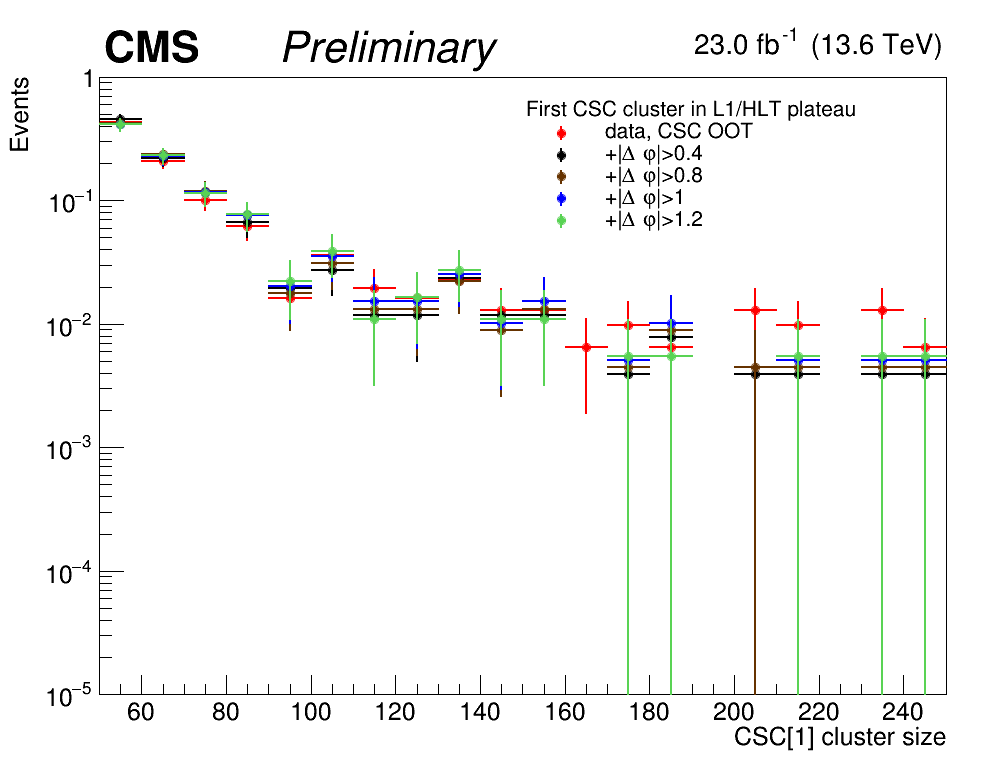

In [27]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}
can.cd()
scale=False
scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (cscClusterTime[k][:,0]>-999)
            cut = (cscClusterTime[k][:,0]<0)
        if k=='signal':
            cut = (cscClusterTime[k][:,0]>-999)
            
        #Clusters in different endcaps, not affected by delta phi bumps
        cut = cut & ( np.abs(dEta_csc_csc[k])>1.5 )
            
        dphi_var_sel = np.abs(dPhi_csc_csc[k][cut])
        bins = [20,50,450]
        #bins = [10,50,1050]
        bins = [20,50,250]
        h0[k] = create_TH1D( cscClusterSize[k][cut][:,0],title="",axis_title = ['CSC[1] cluster size','Events'], binning=bins)
        h0[k].SetLineColor(2)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(2)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        h1[k] = create_TH1D( cscClusterSize[k][cut][dphi_var_sel>0.4][:,0],title="",axis_title = ['CSC[1] cluster size','Events'], binning=bins)
        h1[k].SetLineColor(1)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(1)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())

        h2[k] = create_TH1D( cscClusterSize[k][cut][dphi_var_sel>0.8][:,0],title="",axis_title = ['CSC[1] cluster size','Events'], binning=bins)
        h2[k].SetLineColor(803)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(803)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
        h3[k] = create_TH1D( cscClusterSize[k][cut][dphi_var_sel>1.0][:,0],title="",axis_title = ['CSC[1] cluster size','Events'], binning=bins)
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(20)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        h4[k] = create_TH1D( cscClusterSize[k][cut][dphi_var_sel>1.2][:,0],title="",axis_title = ['CSC[1] cluster size','Events'], binning=bins)
        h4[k].SetLineColor(8)
        h4[k].SetLineWidth(2)
        h4[k].SetMarkerColor(8)
        h4[k].SetMarkerStyle(20)
        h4[k].SetMarkerSize(1.2)
        if scale and h4[k].Integral()>0:h4[k].Scale(1./h4[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.8)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.00001)
        if 'data' in k:
            h0[k].Draw('PE same')
            h1[k].Draw('PE same')
            h2[k].Draw('PE same')
            h3[k].Draw('PE same')
            h4[k].Draw('PE same')
            leg.AddEntry(h0[k],"data, CSC OOT","PE")
            leg.AddEntry(h1[k],"+|#Delta #varphi|>0.4","PE")
            leg.AddEntry(h2[k],"+|#Delta #varphi|>0.8","PE")
            leg.AddEntry(h3[k],"+|#Delta #varphi|>1","PE")
            leg.AddEntry(h4[k],"+|#Delta #varphi|>1.2","PE")
        #else:
        #    h0[k].Draw('HISTO same')
        #    h1[k].Draw('HISTO same')
        #    h2[k].Draw('HISTO same')
        #    h3[k].Draw('HISTO same')
        #    h4[k].Draw('HISTO same')
        #    leg.AddEntry(h0[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` 

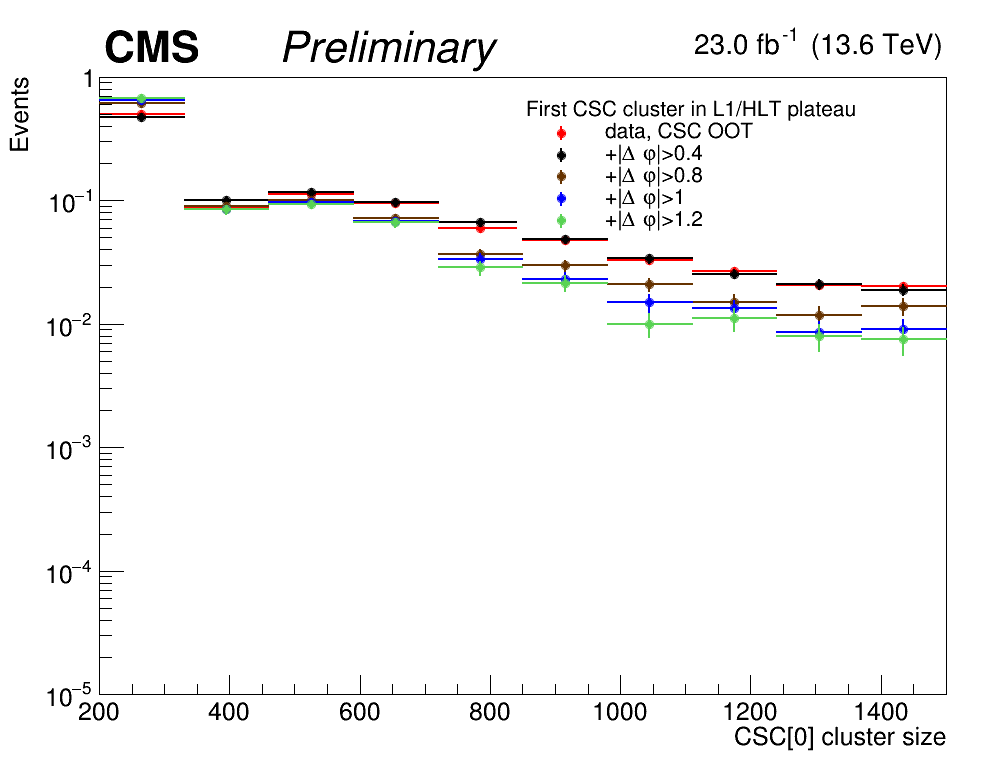

In [28]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}
can.cd()
scale=False
scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (cscClusterTime[k][:,0]>-999)
        if k=='signal':
            cut = (cscClusterTime[k][:,0]>-999)
            
        dphi_var_sel = np.abs(dPhi_csc_csc[k][cut])
        bins = [10,200,1500]
        h0[k] = create_TH1D( tr_cscClusterSize[k][cut][:,0],title="",axis_title = ['CSC[0] cluster size','Events'], binning=bins)
        h0[k].SetLineColor(2)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(2)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        h1[k] = create_TH1D( tr_cscClusterSize[k][cut][dphi_var_sel>0.4][:,0],title="",axis_title = ['CSC[0] cluster size','Events'], binning=bins)
        h1[k].SetLineColor(1)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(1)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())

        h2[k] = create_TH1D( tr_cscClusterSize[k][cut][dphi_var_sel>0.8][:,0],title="",axis_title = ['CSC[0] cluster size','Events'], binning=bins)
        h2[k].SetLineColor(803)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(803)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
        h3[k] = create_TH1D( tr_cscClusterSize[k][cut][dphi_var_sel>1.0][:,0],title="",axis_title = ['CSC[0] cluster size','Events'], binning=bins)
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(20)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        h4[k] = create_TH1D( tr_cscClusterSize[k][cut][dphi_var_sel>1.2][:,0],title="",axis_title = ['CSC[0] cluster size','Events'], binning=bins)
        h4[k].SetLineColor(8)
        h4[k].SetLineWidth(2)
        h4[k].SetMarkerColor(8)
        h4[k].SetMarkerStyle(20)
        h4[k].SetMarkerSize(1.2)
        if scale and h4[k].Integral()>0:h4[k].Scale(1./h4[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.8)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.00001)
        if 'data' in k:
            h0[k].Draw('PE same')
            h1[k].Draw('PE same')
            h2[k].Draw('PE same')
            h3[k].Draw('PE same')
            h4[k].Draw('PE same')
            leg.AddEntry(h0[k],"data, CSC OOT","PE")
            leg.AddEntry(h1[k],"+|#Delta #varphi|>0.4","PE")
            leg.AddEntry(h2[k],"+|#Delta #varphi|>0.8","PE")
            leg.AddEntry(h3[k],"+|#Delta #varphi|>1","PE")
            leg.AddEntry(h4[k],"+|#Delta #varphi|>1.2","PE")
        #else:
        #    h0[k].Draw('HISTO same')
        #    h1[k].Draw('HISTO same')
        #    h2[k].Draw('HISTO same')
        #    h3[k].Draw('HISTO same')
        #    h4[k].Draw('HISTO same')
        #    leg.AddEntry(h0[k],"signal","L")
        #h0[k].Delete()
        #h1[k].Delete()

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` 

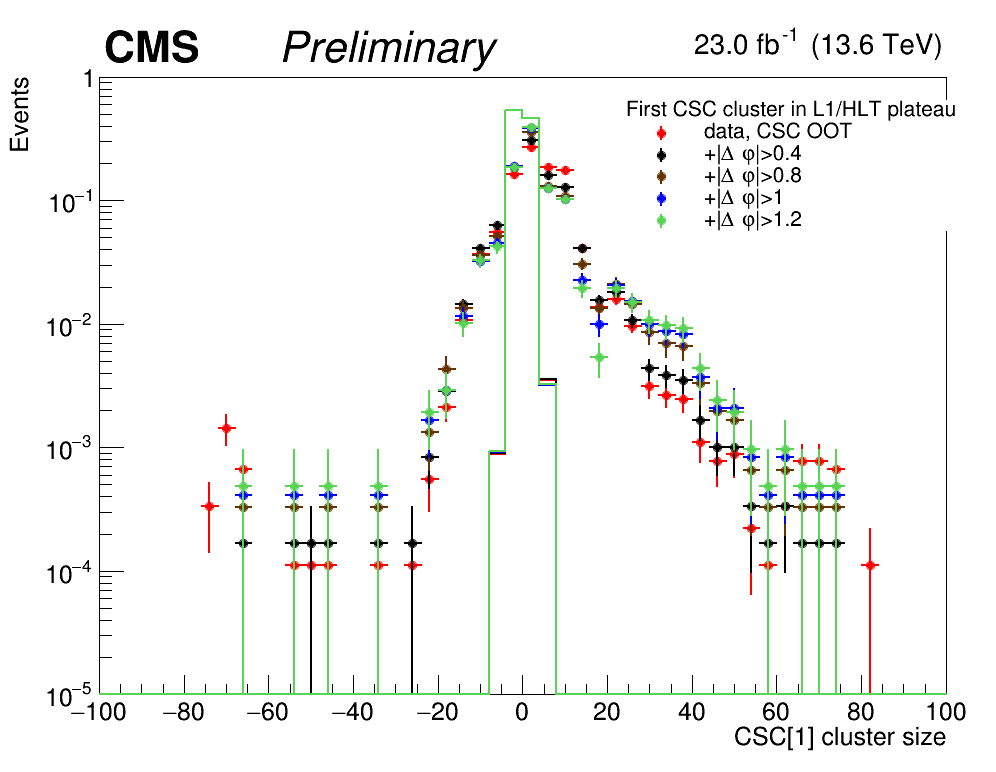

In [29]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.5,0.7,0.37+0.6,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}
can.cd()
scale=False
scale=True

leg.SetHeader("First CSC cluster in L1/HLT plateau")
lab = ""
       
for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (cscClusterTime[k][:,0]>-999)
            #cut = (cscClusterTime[k][:,0]<0)
        if k=='signal':
            cut = (cscClusterTime[k][:,0]>-999)
            
        dphi_var_sel = np.abs(dPhi_csc_csc[k][cut])
        var = cscClusterSize[k]
        bins = [10,50,1050]
        var = cscClusterPhi[k]
        bins = [40,-3.2,3.2]
        var = tr_cscClusterEta[k]
        bins = [50,-3.,3.]
        var = tr_cscClusterTime[k]
        bins = [50,-100.,100.]
        #var = cscClusterDNN[k]
        #bins = [50,0.,1.]
        h0[k] = create_TH1D( var[cut][:,0],title="",axis_title = ['CSC[1] cluster size','Events'], binning=bins)
        h0[k].SetLineColor(2)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(2)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        h1[k] = create_TH1D( var[cut][dphi_var_sel>0.4][:,0],title="",axis_title = ['CSC[1] cluster size','Events'], binning=bins)
        h1[k].SetLineColor(1)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(1)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())

        h2[k] = create_TH1D( var[cut][dphi_var_sel>0.8][:,0],title="",axis_title = ['CSC[1] cluster size','Events'], binning=bins)
        h2[k].SetLineColor(803)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(803)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
        h3[k] = create_TH1D( var[cut][dphi_var_sel>1.0][:,0],title="",axis_title = ['CSC[1] cluster size','Events'], binning=bins)
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(20)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        h4[k] = create_TH1D( var[cut][dphi_var_sel>1.2][:,0],title="",axis_title = ['CSC[1] cluster size','Events'], binning=bins)
        h4[k].SetLineColor(8)
        h4[k].SetLineWidth(2)
        h4[k].SetMarkerColor(8)
        h4[k].SetMarkerStyle(20)
        h4[k].SetMarkerSize(1.2)
        if scale and h4[k].Integral()>0:h4[k].Scale(1./h4[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.8)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.00001)
        if 'data' in k:
            h0[k].Draw('PE same')
            h1[k].Draw('PE same')
            h2[k].Draw('PE same')
            h3[k].Draw('PE same')
            h4[k].Draw('PE same')
            leg.AddEntry(h0[k],"data, CSC OOT","PE")
            leg.AddEntry(h1[k],"+|#Delta #varphi|>0.4","PE")
            leg.AddEntry(h2[k],"+|#Delta #varphi|>0.8","PE")
            leg.AddEntry(h3[k],"+|#Delta #varphi|>1","PE")
            leg.AddEntry(h4[k],"+|#Delta #varphi|>1.2","PE")
        else:
            h0[k].Draw('HISTO same')
            h1[k].Draw('HISTO same')
            h2[k].Draw('HISTO same')
            h3[k].Draw('HISTO same')
            h4[k].Draw('HISTO same')

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` 

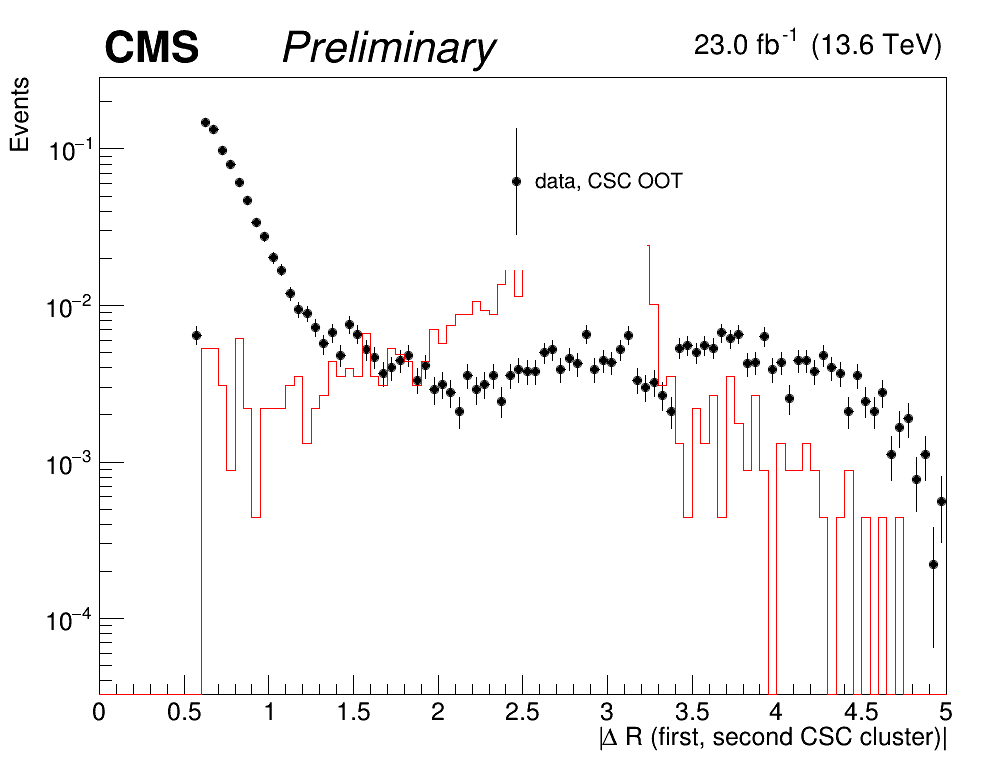

In [30]:
if category == 1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    hoot = {}
    can.cd()

    for k in tree_keys:
        if k=='data':
            #Select OOT DT clusters to avoid unblinding
            #cut = (dtClusterTime[k][:,0].flatten()!=-999999)#!=0)
            cut = (cscClusterTime[k][:,0]>-999)
            #cut = (cscClusterTime[k][:,0]<0)
        if k=='signal':
            cut = (cscClusterTime[k][:,0]>-999)
            
        dphi_var_sel = np.abs(dPhi_csc_csc[k][cut])
        deta_var_sel = np.abs(dEta_csc_csc[k][cut])
        dR_var_sel = np.abs(dR_csc_csc[k][cut])
        
        
        var = dphi_var_sel
        bins=[100,0,3.2]
        title = '|#Delta #varphi (first, second CSC cluster)|'
        var = deta_var_sel
        bins=[100,0,5]
        title = '|#Delta #eta (first, second CSC cluster)|'
        var = dR_var_sel
        bins=[100,0,5]
        title = '|#Delta R (first, second CSC cluster)|'
        cut = cut #& (np.abs(dEta_csc_csc[k])>1.5)
        
        h0[k] = create_TH1D(var[cut],title="",axis_title = [title,'Events'], binning=bins)

        if scale:
            h0[k].Scale(1./h0[k].Integral())
        #if not scale:
        #    h0[k].SetMinimum(0.8)
        #    h0[k].SetMaximum(1.e5)
        #else:
        #    h0[k].SetMaximum(1)
        #    h0[k].SetMinimum(0.00001)
        if 'data' in k:
            h0[k].SetMarkerStyle(20)
            h0[k].SetMarkerColor(1)
            h0[k].SetLineColor(1)
            h0[k].Draw('PE same')
            #h1[k].Draw('PE same')
            #h2[k].Draw('PE same')
            #h3[k].Draw('PE same')
            #h4[k].Draw('PE same')
            leg.AddEntry(h0[k],"data, CSC OOT","PE")
            #leg.AddEntry(h1[k],"+|#Delta #varphi|>0.4","PE")
            #leg.AddEntry(h2[k],"+|#Delta #varphi|>0.8","PE")
            #leg.AddEntry(h3[k],"+|#Delta #varphi|>1","PE")
            #leg.AddEntry(h4[k],"+|#Delta #varphi|>1.2","PE")
        else:
            h0[k].SetLineColor(2)
            h0[k].Draw('HISTO same')
            #h1[k].Draw('HISTO same')
            #h2[k].Draw('HISTO same')
            #h3[k].Draw('HISTO same')
            #h4[k].Draw('HISTO same')

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` 

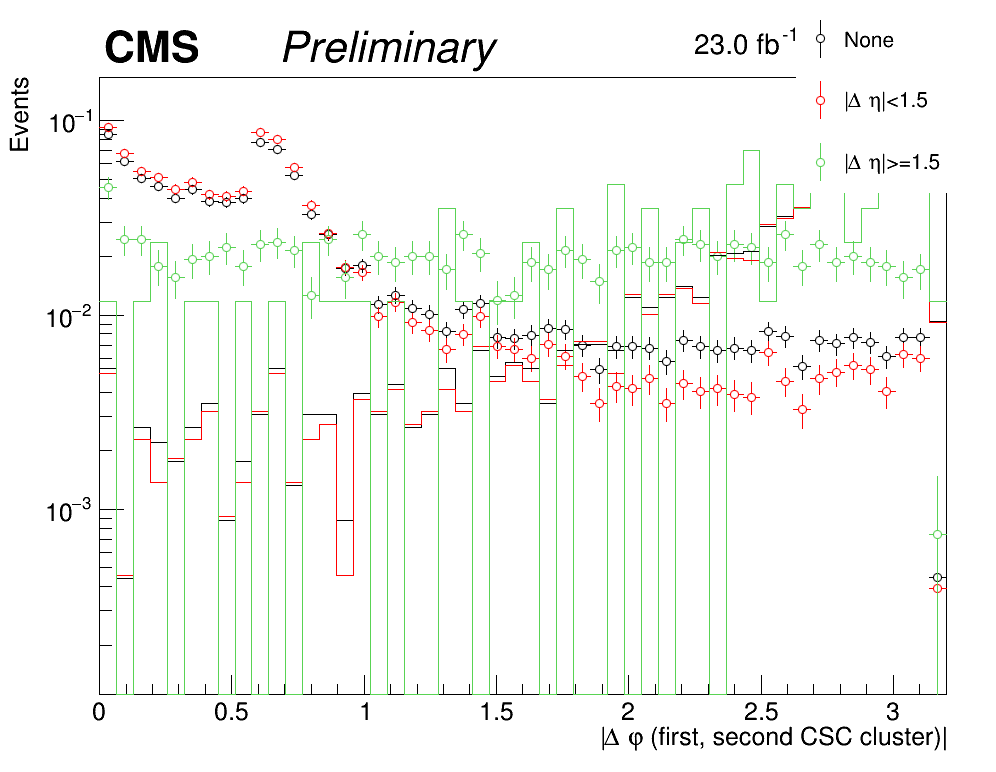

In [31]:
if category == 1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5+0.3,0.75,0.99,0.99)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    can.cd()
    colors = [1,2,8]
    colors1 = [801,450,880]

    for k in tree_keys:
        if k=='data':
            cut = (cscClusterTime[k][:,0]>-999)
        if k=='signal':
            cut = (cscClusterTime[k][:,0]>-999)
            
        selections = [
            cut,
            #cut & (np.abs(dEta_csc_csc[k])<1.5) & (tr_cscClusterEta[k][:,0]>0),
            #cut & (np.abs(dEta_csc_csc[k])>=1.5) & (tr_cscClusterEta[k][:,0]>0),
            cut & (np.abs(dEta_csc_csc[k])<1.5),
            cut & (np.abs(dEta_csc_csc[k])>=1.5),
        ]
        
        selections_labels = [
            "None",
            "|#Delta #eta|<1.5",
            "|#Delta #eta|>=1.5",
        ]
        
        for i, sel in enumerate(selections):
            dphi_var_sel = np.abs(dPhi_csc_csc[k][sel])
            deta_var_sel = np.abs(dEta_csc_csc[k][sel])
            dR_var_sel = np.abs(dR_csc_csc[k][sel])
        
        
            double_vars = []
            var = dphi_var_sel
            bins=[50,0,3.2]
            title = '|#Delta #varphi (first, second CSC cluster)|'
            #var = deta_var_sel
            #bins=[100,0,5]
            #title = '|#Delta #eta (first, second CSC cluster)|'
            #var = dR_var_sel
            #bins=[100,0,5]
            #title = '|#Delta R (first, second CSC cluster)|'
            #double_vars = [tr_cscClusterEta[k][sel][:,0],cscClusterEta[k][sel][:,0]]
            #bins=[50,-3.2,3.2]
            #title = 'Cluster #eta'
            
            if double_vars==[]:
                h0[k+str(i)] = create_TH1D(var,title="",axis_title = [title,'Events'], binning=bins)
            else:
                h0[k+str(i)] = create_TH1D(double_vars[0],title="",axis_title = [title,'Events'], binning=bins)
                h1[k+str(i)] = create_TH1D(double_vars[1],title="",axis_title = [title,'Events'], binning=bins)
                if scale:
                    h1[k+str(i)].Scale(1./h1[k+str(i)].Integral())  
            
            if scale:
                h0[k+str(i)].Scale(1./h0[k+str(i)].Integral())    

            if 'data' in k:
                h0[k+str(i)].SetMarkerStyle(24)
                h0[k+str(i)].SetMarkerColor(colors[i])
                h0[k+str(i)].SetLineColor(colors[i])
                h0[k+str(i)].Draw('PE same')
                leg.AddEntry(h0[k+str(i)],selections_labels[i],"PE")
                if double_vars!=[]:
                    h1[k+str(i)].SetMarkerStyle(25)
                    h1[k+str(i)].SetMarkerColor(colors1[i])
                    h1[k+str(i)].SetLineColor(colors1[i])
                    h1[k+str(i)].Draw('PE same')
                    leg.AddEntry(h1[k+str(i)],selections_labels[i],"PE")                    
            else:
                h0[k+str(i)].SetLineColor(colors[i])
                h0[k+str(i)].Draw('HISTO same')
                if double_vars!=[]:
                    h1[k+str(i)].SetLineColor(colors1[i])
                    h1[k+str(i)].SetLineStyle(2)
                    h1[k+str(i)].Draw('HISTO same')


can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
leg.Draw()
can.SetLogy()
can.Draw()
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".pdf")
#can.Print("plots/V1p19_"+vers+"/DeltaPhi_HLT_categories"+lab+plot_string+".png")
#can.Close() 

# ABCD with N hits

We will need different categories depending on the trigger cluster size

tr_in_plateau_ME11 : 500
tr_in_plateau_ME12 : 500
tr_in_plateau_ME13 : 500
tr_in_plateau_ME21 : 500

tr_in_plateau_ME22 : 200
tr_in_plateau_ME31 : 200
tr_in_plateau_ME32 : 200
tr_in_plateau_ME41 : 200
tr_in_plateau_ME42 : 200

x 	 pred 	 up 	 down 	 true 
275.0 1.625746669169574 1.6730590352877717 1.7037238375052666 6.0
x 	 pred 	 up 	 down 	 true 
325.0 1.1630325695827828 1.2304283910211817 1.1855834548385522 6.0
x 	 pred 	 up 	 down 	 true 
375.0 0.8635907002840529 0.9416567539401204 0.8541379294259759 8.0
x 	 pred 	 up 	 down 	 true 
425.0 0.656888345565563 0.7394645082017944 0.6293185002724061 6.0
x 	 pred 	 up 	 down 	 true 
475.0 0.5079689234178904 0.591013337385176 0.47084907933763026 2.0
x 	 pred 	 up 	 down 	 true 
525.0 0.397464583071211 0.47834942598269015 0.35616917845293544 4.0






/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` 

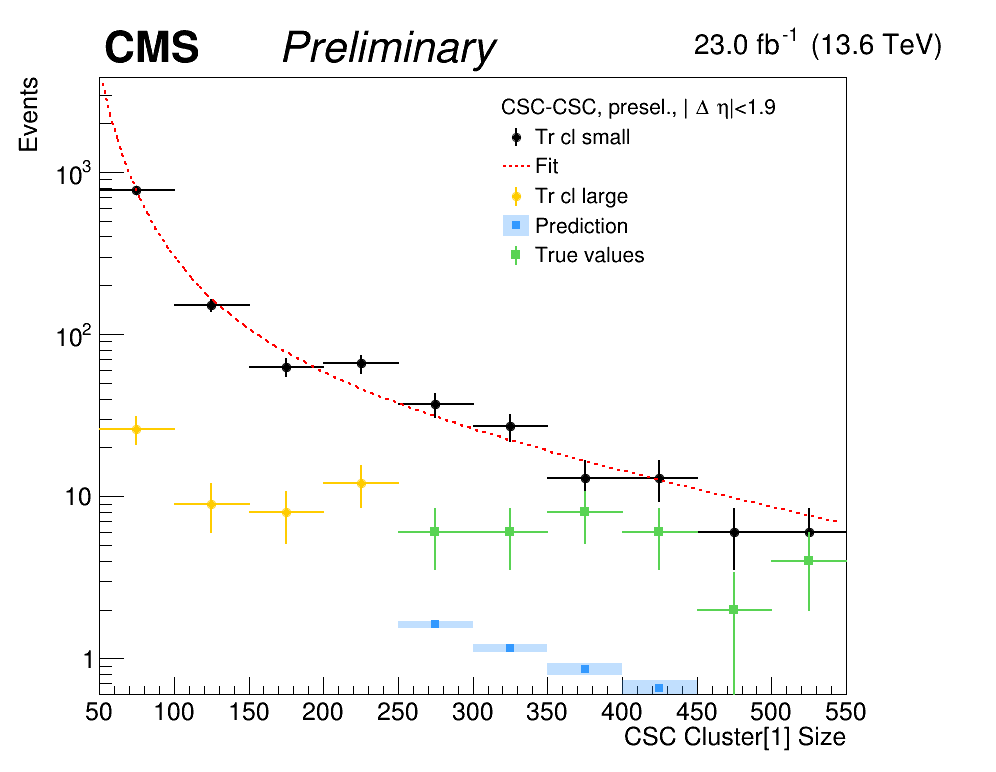

In [32]:
x_min = 50
x_max = 250
x_max = 1050
x_max = 550
n_bins = 10
blinding_bin = 2

n_bins = 10
blinding_bin = 4

bins = np.linspace(x_min,x_max,n_bins+1)
bins_center = bins[0:-1]+0.5*(x_max-x_min)/n_bins

x1_min = 500
x2_min = 200
x1_max = 50000
x2_max = 50000
x1_cut = 1000
x2_cut = 800

N_MIN = x_min
N_MAX = x_max
N_CUT = bins[blinding_bin]

pre_cut = {}

if category == 1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    
    h = {}
    hnot = {}
    hunbl = {}
    hpred= {}
    can.cd()
    
    f1 = rt.TF1("f1","exp([0]*x + [1]/(x))/[2]",x_min,x_max)
    f1.SetParameter(0,-0.03)
    f1.SetParameter(1,200)
    f1.SetParameter(2,74)
    foot = rt.TF1("foot","exp([0]*x + [1]/(x))/[2]",x_min,x_max)
    foot.SetParameter(0,-0.0069210997892010535)
    foot.SetParameter(1,426.659535750436)
    foot.SetParameter(2,195.1699385925665)
    #e^{-x/(a+bx)
    
    scale = True
    scale = False
    do_blind = True
    
    x_pred = []
    x_pred_unc = []
    y_pred = []
    y_pred_up = []
    y_pred_down = []
    y_pred_unc = []

    for k in tree_keys:
        tmp_dphi = np.abs( dPhi_csc_csc[k] )
        tmp_deta = np.abs(  dEta_csc_csc[k] )
        tmp_dR = np.abs(  dR_csc_csc[k] )
        tmp_dt = np.abs( dt_csc_csc[k] )
        tmp_t2 = (cscClusterTime[k][:,0])
        
        tr_in_1 = tr_in_plateau_1[k]
        tr_in_2 = tr_in_plateau_2[k]
        
        ev_pl_1 = ak.any(tr_in_plateau_1[k],axis=1)
        ev_pl_2 = ak.any(tr_in_plateau_2[k],axis=1)
        
        tmp_size1 = (tr_cscClusterSize[k] [tr_in_1] )
        tmp_size2 = (tr_cscClusterSize[k] [tr_in_2] )
        
        blind = (cscClusterSize[k][:,0] < bins[blinding_bin] if do_blind else 100000 )
        unblind = (cscClusterSize[k][:,0] >= bins[blinding_bin])
        
        #Eta<1.9      
        leg.SetHeader('CSC-CSC, presel., |#Delta #eta|<1.9')
        pre_cut[k] = (tmp_deta<1.9) & (tmp_dphi>0.8) & (tmp_dR>0.8) & (tmp_dphi<2.8)# & (np.abs(dEta_csc_csc[k])<0.4))#(tmp_deta>0.7)# & (np.abs(tmp_t2)<50) # & (sel_jetveto_csc[k][:,0]==True)#& (tmp_deta<0.3) 
        
        #pre_cut[k] = pre_cut[k] & (cscClusterSize[k][:,0]>100)
        
        #Invert jet veto
        #leg.SetHeader('CSC-CSC, presel., inverted jet veto')
        #pre_cut[k] = (sel_jetveto_csc[k][:,0]==False) #& (np.abs(dPhi_csc_csc[k])>PHI_MIN)# & (np.abs(dEta_csc_csc[k])<0.4))#(tmp_deta>0.7)# & (np.abs(tmp_t2)<50) # & (sel_jetveto_csc[k][:,0]==True)#& (tmp_deta<0.3) 

        #Eta>=1.9      
        #leg.SetHeader('CSC-CSC, presel., |#Delta #eta|#geq1.9')
        #pre_cut[k] = (tmp_deta>=1.9)# & (np.abs(dEta_csc_csc[k])<0.4))#(tmp_deta>0.7)# & (np.abs(tmp_t2)<50) # & (sel_jetveto_csc[k][:,0]==True)#& (tmp_deta<0.3) 

        #Eta>=1.9 OOT negative
        #leg.SetHeader('CSC-CSC, presel., |#Delta #eta|#geq1.9')
        #pre_cut[k] = (tmp_deta>=1.9) & (tmp_t2<-15)# & (np.abs(dEta_csc_csc[k])<0.4))#(tmp_deta>0.7)# & (np.abs(tmp_t2)<50) # & (sel_jetveto_csc[k][:,0]==True)#& (tmp_deta<0.3) 
        
        #Eta<1.9 & DR>0.8  
        #leg.SetHeader('CSC-CSC, presel., |#Delta#eta|<1.9, #DeltaR>'+str(DR_MIN))
        #pre_cut[k] = sel_ev_post[k] & (tmp_deta<1.9) & (tmp_dR>DR_MIN) # & (np.abs(dEta_csc_csc[k])<0.4))#(tmp_deta>0.7)# & (np.abs(tmp_t2)<50) # & (sel_jetveto_csc[k][:,0]==True)#& (tmp_deta<0.3) 
         
        cut_tr_small = ( (tmp_size2 > x2_min) & (tmp_size2 < x2_cut) )#(tmp_dphi>=PHI_MIN) & (tmp_dphi<PHI_CUT)
        cut_tr_large = ( (tmp_size2 >= x2_cut) & (tmp_size2 < x2_max) ) #(tmp_dphi>=PHI_CUT) & (tmp_dphi<PHI_MAX) 
        cut = (cut_tr_small==True)
        cut_label = "Tr cl small"#str(PHI_MIN)+" < #Delta #varphi (CSC,CSC) < "+str(PHI_CUT)
        cut_not = (cut_tr_large==True)
        cut_not_label = "Tr cl large"#str(PHI_CUT)+" < #Delta #varphi (CSC,CSC) < "+str(PHI_MAX)
        
        
        csc_size_2 = cscClusterSize[k][ pre_cut[k] & cut ]
        csc_size_2_not = cscClusterSize[k][ pre_cut[k] & cut_not & blind ]
        csc_size_2_unbl = cscClusterSize[k][ pre_cut[k] & cut_not & unblind ]
        
        h[k] = create_TH1D(ak.flatten(csc_size_2),title="",axis_title = ['CSC Cluster[1] Size','Events'], binning=bins,bin_list=True)
        h[k].SetLineColor(1)
        h[k].SetLineWidth(2)
        h[k].SetMarkerColor(1)
        h[k].SetMarkerStyle(20)
        h[k].SetMarkerSize(1.2)
        
        
        hnot[k] = create_TH1D(ak.flatten(csc_size_2_not),title="",axis_title = ['CSC Cluster[1] Size','Events'], binning=bins,bin_list=True)
        hnot[k].SetLineColor(800)
        hnot[k].SetLineWidth(2)
        hnot[k].SetMarkerColor(800)
        hnot[k].SetMarkerStyle(20)
        hnot[k].SetMarkerSize(1.2)
        
        hunbl[k] = create_TH1D(ak.flatten(csc_size_2_unbl),title="",axis_title = ['CSC Cluster[1] Size','Events'], binning=bins,bin_list=True)
        hunbl[k].SetLineColor(8)
        hunbl[k].SetLineWidth(2)
        hunbl[k].SetMarkerColor(8)
        hunbl[k].SetMarkerStyle(21)
        hunbl[k].SetMarkerSize(1.2)
                
        if scale:
            h[k].Scale(1./h[k].Integral() if h[k].Integral()>0 else 1.)
            hnot[k].Scale(1./hnot[k].Integral() if hnot[k].Integral()>0 else 1.)
            hunbl[k].Scale(1./hunbl[k].Integral() if hunbl[k].Integral()>0 else 1.)
            
        h[k].SetMaximum(  5*max(1. if scale else 1.9, max(h[k].GetMaximum(),hnot[k].GetMaximum()) )  )        
        min_y = max(max(h[k].GetMinimum(),1.e-500 if scale else 0.9), max(hnot[k].GetMinimum(),1.e-500 if scale else 0.9))
        h[k].SetMinimum(min(min_y*0.1,0.6 if min_y==0 else 1000))        
        
        if 'data' in k:         
            h[k].Fit('f1', 'LRSQ+', '', x_min,x_max)
            my_f1 = h[k].GetFunction("f1")            
            h[k].GetListOfFunctions().Remove(h[k].GetFunction("f1"))
            #print(my_f1.GetParameter(0),my_f1.GetParError(0))
            #print(my_f1.GetParameter(1),my_f1.GetParError(0))
            #print(my_f1.GetParameter(2),my_f1.GetParError(0))
            my_f1_up = my_f1.Clone("my_f1_up")
            my_f1_down = my_f1.Clone("my_f1_down")
            my_f1_up.SetParameter(0,  my_f1.GetParameter(0) + my_f1.GetParError(0) )
            my_f1_up.SetParameter(1,  my_f1.GetParameter(1) + my_f1.GetParError(1) )
            my_f1_up.SetParameter(2,  my_f1.GetParameter(2) + my_f1.GetParError(2) )
            my_f1_down.SetParameter(0,  my_f1.GetParameter(0) - my_f1.GetParError(0) )
            my_f1_down.SetParameter(1,  my_f1.GetParameter(1) - my_f1.GetParError(1) )
            my_f1_down.SetParameter(2,  my_f1.GetParameter(2) - my_f1.GetParError(2) )
            #print(foot.GetParameter(0))
            #print(foot.GetParameter(1))
            #print(foot.GetParameter(2))
            h[k].Draw("PE same")
            hnot[k].Draw("PE same")
            my_f1.SetLineStyle(2)
            my_f1.Draw('L same')
            
            leg.AddEntry(h[k],cut_label,"PE")
            leg.AddEntry(my_f1,"Fit","L")
            leg.AddEntry(hnot[k],cut_not_label,"PE")
            
            if not do_blind:
                hnot[k].Fit('foot', 'LRSQ+', '', x_min,x_max)
                my_foot = hnot[k].GetFunction("foot")
                hnot[k].GetListOfFunctions().Remove(hnot[k].GetFunction("foot"))
                my_foot.SetLineColor(4)
                my_foot.Draw('L same')
                leg.AddEntry(my_foot,"Fit","L")
                
            else:
                ratio = hnot[k].Integral(1,blinding_bin)/h[k].Integral(1,blinding_bin)
                my_f1_up.SetLineColor(4)
                my_f1_down.SetLineColor(1)
                #my_f1_up.Draw("L same")
                #my_f1_down.Draw("L same")
                for b in bins_center[blinding_bin:]:
                    print("x \t pred \t up \t down \t true ")
                    print(b,ratio*my_f1.Eval(b), ratio*my_f1_up.Eval(b), ratio*my_f1_down.Eval(b),  hunbl[k].GetBinContent(hunbl[k].FindBin(b)))
                    x_pred.append(b)
                    x_pred_unc.append(0.5*(x_max-x_min)/n_bins)
                    y_pred.append(ratio*my_f1.Eval(b))
                    y_pred_up.append(ratio*my_f1_up.Eval(b))
                    y_pred_down.append(ratio*my_f1_down.Eval(b))
                    y_pred_unc.append(max( abs(ratio*my_f1.Eval(b) - ratio*my_f1_up.Eval(b)) , abs(ratio*my_f1.Eval(b) - ratio*my_f1_down.Eval(b)) ))
                
                
                gr = create_TGraph(x_pred,y_pred,ex=x_pred_unc,ey=y_pred_unc, axis_title = ['',''])
                #print(gr.Print())
                gr.SetFillColorAlpha(861,0.3)
                gr.SetLineColor(861)
                gr.SetLineWidth(0)
                gr.SetMarkerStyle(21)
                gr.SetMarkerColor(861)

                gr.Draw('PE2 same')
                leg.AddEntry(gr,"Prediction","PF")
                hunbl[k].Draw('PE same')
                leg.AddEntry(hunbl[k],"True values","PE")
                
        #if 'signal' in k:
        #    h[k].Draw("HISTO same")
        #    hnot[k].Draw("HISTO same")            
            
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    can.SetLogy()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    #can.Print("plots/V1p19_"+vers+"/CscCscClusterSize_fit_test"+plot_string+".pdf")
    #can.Print("plots/V1p19_"+vers+"/CscCscClusterSize_fit_test"+plot_string+".png")
    print("\n")
    
    print("\n")
    #can.Close()



In [33]:
X_MIN = x2_min
X_CUT = x2_cut
X_MAX = x2_max

N_MIN = 50
N_MAX = 500000000
N_CUT = 150

n_ev = 5000

pre_cut = {}
a = {}
b = {}
c = {}
d = {}

In [34]:
def extrapolation(vec,min_x,max_x,nbins):
    h = create_TH1D(vec,title="",axis_title = ['',''], binning=[nbins,min_x,max_x])#,bin_list=True)
    #can = rt.TCanvas('c','c', 1000, 800)
    #can.cd()
    h.SetLineWidth(2)
    h.SetMarkerStyle(20)
    #f1 = rt.TF1("f1","[0]*x + [1]",min_x,max_x)
    #f1.SetParameter(0,-2)
    #f1.SetParameter(1,60)
    f1 = rt.TF1("f1","exp([0]*x + [1]/(x))/[2]",min_x,max_x)
    f1.SetParameter(0,-0.03)
    f1.SetParameter(1,200)
    f1.SetParameter(2,74)
    h.Fit('f1', 'LRSQ+', '', min_x,max_x)
    my_f1 = h.GetFunction("f1")            
    h.GetListOfFunctions().Remove(h.GetFunction("f1"))
    #h.Draw("PE")
    #h.GetXaxis().SetTitle("#Delta#varphi")
    ##h.SetTitle("High n hits region: "+str(N_CUT)+" < N hits < " + str(N_MAX))
    #my_f1.SetLineStyle(2)
    #my_f1.Draw('L same')
    #can.SetLogy()
    #can.Draw()
    #can.Print("test.pdf")
    #can.Print("test.png")
    return h, my_f1

In [35]:
def run_abcd(var1,var2,MIN1,CUT1,MAX1,MIN2,CUT2,MAX2,sel,x_th=2000,n_th=150,do_b_extrapolation=False):
            
    d = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<CUT2 )])#high n, low phi
    #risk of unblinding D when phi gets too large. Try to predict it instead.
    if CUT2>=x_th:
        low_d = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<x_th )])
        high_d_flat = (CUT2-x_th)*low_d/( x_th - MIN2 )
        d_pred = low_d+high_d_flat
        print("D\t D low\t D pred")
        print("%i\t %i\t  %.2f" % (d,low_d, d_pred))
        d = low_d+high_d_flat  
    b = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>=CUT2 ) & ( var2<MAX2 )])#low n, high phi
    #risk of unblinding B when n hits gets too large. Try to predict it instead.
    if CUT1>=n_th and do_b_extrapolation:
        low_b_vec = var1[sel & (var1>=MIN1) & (var1<n_th) & ( var2>=CUT2 ) & ( var2<MAX2 )]
        low_b = np.sum([sel & (var1>=MIN1) & (var1<n_th) & ( var2>=CUT2 ) & ( var2<MAX2 )])
        h,my_f1 = extrapolation(low_b_vec,MIN1,CUT1,20)
        b_pred = my_f1.Integral(n_th,CUT1) + low_b
        print("B\t B pred")
        print("%i\t%.2f" % (b,b_pred))
        #high_b_flat = (CUT2-phi_th)*low_b/( phi_th - MIN2 )
        b = my_f1.Integral(n_th,CUT1) + low_b
        
    c = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<CUT2 )])#low n, low phi 
    #if CUT2>=phi_th:
    #    #low_c = np.sum([sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<phi_th )])
    #    #high_c_flat = (CUT2-phi_th)*low_c/( phi_th - MIN2 )
    #    #c_pred = low_c+high_c_flat
    #    #print("c\t c low\t c pred")
    #    #print("%i\t %i\t  %.2f" % (c,low_c, c_pred))
    #    #c = low_c+high_c_flat  
    a = np.sum([sel & (var1>=CUT1) & (var1<MAX1) & ( var2>=CUT2 ) & ( var2<MAX2 )])#SR  
    pred = (b*d)/c
    unc_pred = (1./b if b>0 else 0 + 1./d if d>0 else 0 + 1./c if c>0 else 0)**0.5*pred
    if math.isnan(unc_pred): 
        p_value = float("nan")
        z_value = float("nan")
    else:
        mu = np.random.normal(pred, unc_pred, n_ev)
        p_value = 0.0
        for i in mu:
            if i < 0:continue
            n = np.random.poisson(i, n_ev)
            p_value += np.count_nonzero(n>=a)
        p_value = p_value/n_ev**2
        z_value = (norm.ppf(p_value))
    return a,b,c,d,pred,unc_pred, p_value, z_value

In [36]:
def return_abcd_masks(var1,var2,MIN1,CUT1,MAX1,MIN2,CUT2,MAX2,sel):
    d = sel & (var1>=CUT1) & (var1<MAX1) & ( var2>MIN2 ) & ( var2<CUT2 )
    b = sel & (var1>=MIN1) & (var1<CUT1) & ( var2>=CUT2 ) & ( var2<MAX2 ) 
    c = sel & (var1>=MIN1) & (var1<CUT1) & ( var2>MIN2 ) & ( var2<CUT2 )  
    a = sel & (var1>=CUT1) & (var1<MAX1) & ( var2>=CUT2 ) & ( var2<MAX2 )
    return a,b,c,d

In [37]:
def make_datacard_2tag(outDataCardsDir,modelName,  signal_rate, normalization, bkg_rate, observation, bkg_unc, bkg_unc_name, sig_unc, sig_unc_name,signal_region, prefix):
    a,b,c,d = bkg_rate[0], bkg_rate[1], bkg_rate[2], bkg_rate[3]
    nSig = len(signal_rate.keys())
    text_file = open(outDataCardsDir+modelName+".txt", "w")
    text_file.write('# signal norm {0} \n'.format(normalization))

    text_file.write('imax {0} \n'.format(4))
    text_file.write('jmax {0} \n'.format(nSig))
    text_file.write('kmax * \n')
    text_file.write('shapes * * FAKE \n')


    text_file.write('--------------- \n')
    text_file.write('--------------- \n')
    text_file.write('bin \t chA \t chB \t chC \t chD \n')
    text_file.write('observation \t {0:6.2f} \t {1:6.2f} \t {2:6.2f} \t {3:6.2f} \n'.format(observation[0],observation[1],observation[2],observation[3]))
    text_file.write('------------------------------ \n')
    text_file.write('bin '+'\t chA ' * (1+nSig) + '\t chB ' * (1+nSig) +'\t chC '*(1+nSig) +'\t chD '*(1+nSig) +'\n')
    process_name = '\t '+ (' \t ').join(list(signal_rate.keys())) + '\t bkg '
    text_file.write('process ' + process_name * 4 + '\n')
    process_number = '\t '+ (' \t ').join(list((np.arange(nSig)*-1).astype(str))) + '\t 1'
    text_file.write('process ' + process_number * 4 + '\n')
    rate_string = 'rate'
    for i in range(4):# 4 bins
        for k,v in signal_rate.items():
            rate_string +='\t {0:e} '.format(v[i])
        rate_string += '\t 1 '
    text_file.write(rate_string+'\n')
    text_file.write('------------------------------ \n')

    text_file.write(prefix+'A   rateParam       chA     bkg      (@0*@2/@1)                    '+prefix+'B,'+prefix+'C,'+prefix+'D \n')
    if b == 0: text_file.write(prefix+'B   rateParam       chB     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(b, c*7))
    else: text_file.write(prefix+'B   rateParam       chB     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(b, b*7))
    text_file.write(prefix+'C   rateParam       chC     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(c, c*7))
    if d == 0:text_file.write(prefix+'D   rateParam       chD     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(d, c*7))
    else: text_file.write(prefix+'D   rateParam       chD     bkg     {0:.2f}        [0,{1:.2f}] \n'.format(d, d*7))


    #for k,v in signal_rate.items():
    #    text_file.write('norm rateParam * {0} 1  \n'.format(k))
        
    '''


  #### uncertainties ####
    for k,v in sig_unc.items():assert(len(sig_unc_name)==len(v))
    for i in range(len(sig_unc_name)):
        if 'mc_stats' in sig_unc_name[i]:
            for j, bin in enumerate(['A', 'B', 'C', 'D']):#bin
                    for l, k in enumerate(sig_unc.keys()): #channels
                        before = (len(sig_unc.keys())+1)*j+l
                        after = (len(sig_unc.keys())+1)*4-before-1
                        if sig_unc[k][i][j] > 0.0: text_file.write(sig_unc_name[i]+'_'+k+'_'+bin+' \t gmN ' +str(int(sig_unc[k][i][j]))+ '  '+'\t -  '*before + str(signal_rate[k][j]/int(sig_unc[k][i][j])) + '\t - '*after +'\n')

        else:

            unc_text = sig_unc_name[i]+' \t lnN'
            if len(sig_unc[list(sig_unc.keys())[0]][i])==4:#symmetric uncertainties
                for j in range(4):#bin
                    for k,v in sig_unc.items():
                        if v[i][j] == 0.0:unc_text += ' \t -'
                        else: unc_text += ' \t '+str(v[i][j]+1)
                    unc_text += '\t - '
            else:#asymmetric
                for j in range(4):#bin A, B, C, D
                    for k,v in sig_unc.items():
                        if  v[i][j] == 0.0 and v[i][j+4] == 0.0: unc_text += ' \t -'
                        else:unc_text += ' \t {0}/{1}'.format(1-v[i][j],1+v[i][j+4])
                    unc_text += '\t -'
            text_file.write(unc_text + ' \n')
    '''
    for i in range(len(bkg_unc_name)):
        bkg_unc_text = bkg_unc_name[i] + ' \t lnN ' + '\t - '*(4*nSig+3) + '\t ' + str(1+bkg_unc[i]) + ' \n'
        text_file.write(bkg_unc_text)
    

    text_file.close()


## SR background levels

## Scan x cut

/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


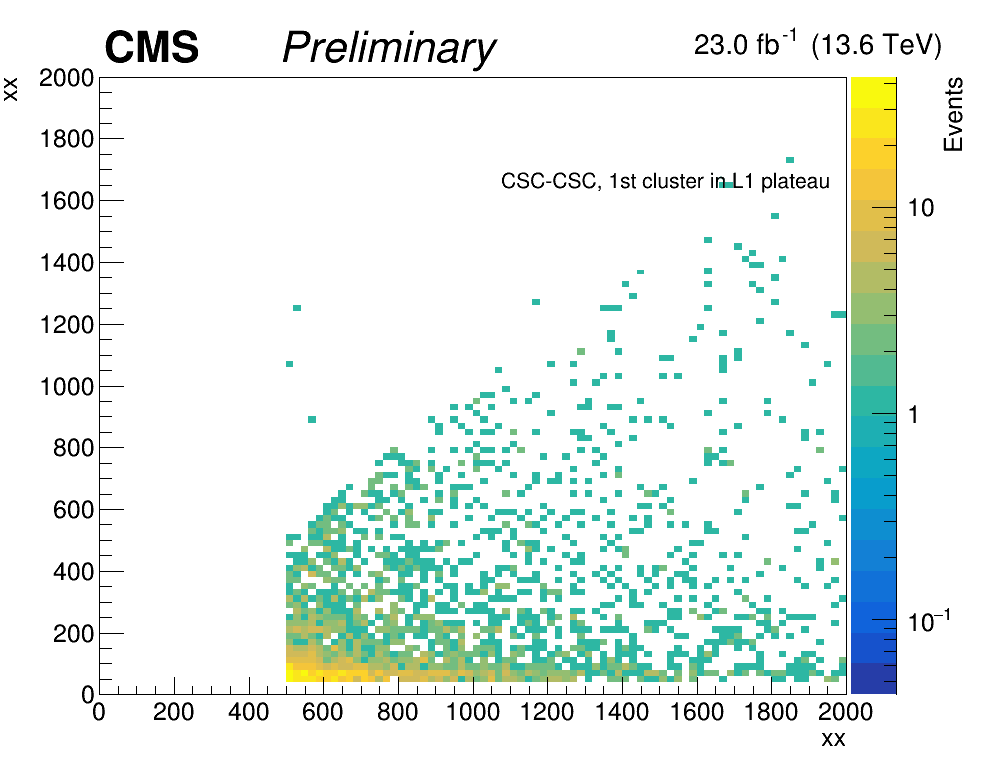

In [38]:
if category == 2 or category==1:
    can = rt.TCanvas('c','c', 1000, 800)
    leg = rt.TLegend(0.5,0.65,0.65,0.88)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h0 = {}
    h1 = {}
    hsm = {}
    hg = {}
    h2 = {}
    can.cd()

    for k in ['data']:
        tr_in_1 = tr_in_plateau_1[k]
        tr_in_2 = tr_in_plateau_2[k]
        
        ev_pl_1 = ak.any(tr_in_plateau_1[k],axis=1)
        ev_pl_2 = ak.any(tr_in_plateau_2[k],axis=1)
                
        tmp_size1 = tr_cscClusterSize[k] [ev_pl_1][:,0]
        tmp_size2 = tr_cscClusterSize[k] [ev_pl_2][:,0]
        
        ev_pl_ch = ev_pl_1
        tmp_size_ch = tmp_size1
        X_MIN = x1_min
        
        tmp_dphi = np.abs( dPhi_csc_csc[k][ev_pl_ch] )
        tmp_deta = np.abs(  dEta_csc_csc[k][ev_pl_ch] )
        tmp_dR = np.abs(  dR_csc_csc[k][ev_pl_ch] )
        tmp_dt = np.abs( dt_csc_csc[k][ev_pl_ch] )
        
        var = cscClusterSize[k][ev_pl_ch][:,0]
        t_var = cscClusterTime[k][ev_pl_ch][:,0]
        tr_t_var = tr_cscClusterTime[k][ev_pl_ch][:,0]
        t_spread_var = cscClusterTimeSpread[k][ev_pl_ch][:,0]
        
        dphi = np.abs(dPhi_csc_csc[k][ev_pl_ch])
        dnn = cscClusterDNN[k][ev_pl_ch][:,0]
        tr_dnn = tr_cscClusterDNN[k][ev_pl_ch][:,0]
        h2[k] = create_TH2D( np.vstack( (np.array(tmp_size_ch), np.array(var)) ).T,title="",axis_title = ['xx','xx','Events'], binning=[100,0,2000,100,0,2000])
        leg.SetHeader('CSC-CSC, 1st cluster in L1 plateau' if category==1 else 'DT-CSC, CSC cluster in L1 plateau')
        h2[k].Draw("colz")

        
    leg.Draw()
    can.SetRightMargin(0.15)
    # if setlog: 
    can.SetLogz()
    can.Draw()
    drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
    #can.Print("plots/V1p19_"+plot_folder+"/GenDeltaR_vs_MET_in_plateau"+plot_string+".pdf")
    #can.Print("plots/V1p19_"+plot_folder+"/GenDeltaR_vs_MET_in_plateau"+plot_string+".png")
    #can.Close()

(3108,)
(9006,)
Bumps appear depending on dR/dphi cuts!


/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` 

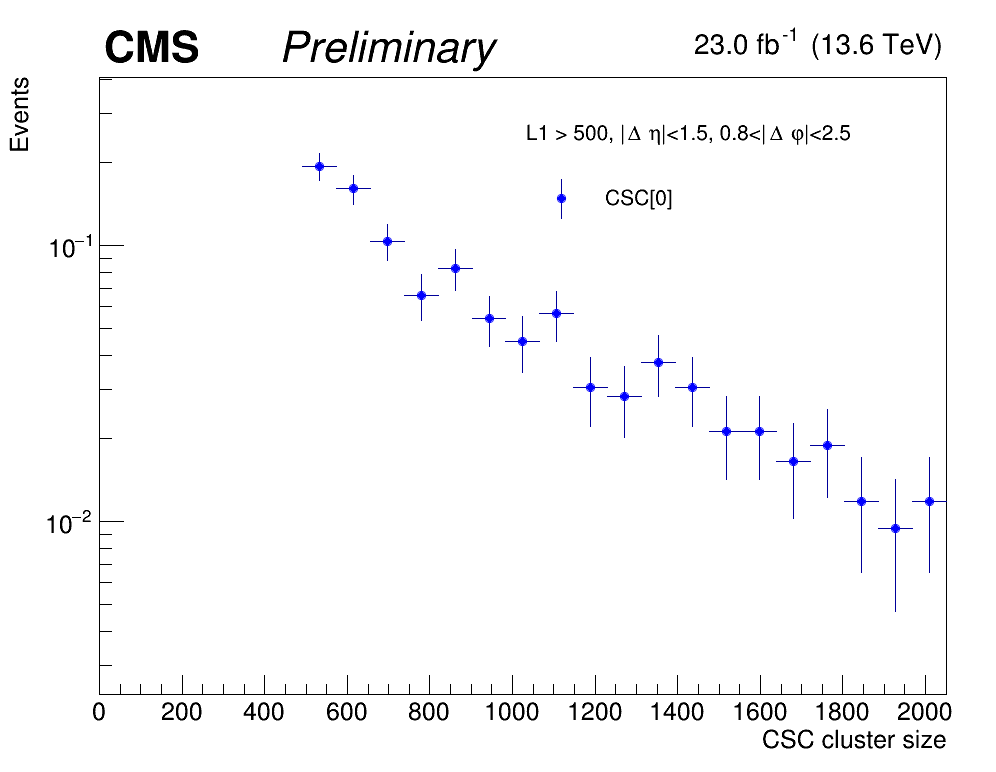

In [78]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}
tr_h0 = {}
tr_h1 = {}
can.cd()
scale=False
scale=True

       
for k in ['data']:
        tr_in_1 = tr_in_plateau_1[k]
        tr_in_2 = tr_in_plateau_2[k]
        
        ev_pl_1 = ak.any(tr_in_plateau_1[k],axis=1)
        ev_pl_2 = ak.any(tr_in_plateau_2[k],axis=1)
                
        tmp_size1 = tr_cscClusterSize[k] [ev_pl_1][:,0]
        tmp_size2 = tr_cscClusterSize[k] [ev_pl_2][:,0]
        
        ev_pl_ch = ev_pl_1
        tmp_size_ch = tmp_size1
        X_MIN = x1_min
        
        leg.SetHeader("L1 > 500, |#Delta #eta|<1.5, 0.8<|#Delta #varphi|<2.5")
        lab = "_L1_500_dEta_0_1p5_dphi_0p8_2p5"
        
        print(np.array(tmp_size_ch).shape)
        print(np.array(ev_pl_ch).shape)
        
        tmp_dphi = np.abs( dPhi_csc_csc[k][ev_pl_ch] )
        tmp_deta = np.abs(  dEta_csc_csc[k][ev_pl_ch] )
        tmp_dR = np.abs(  dR_csc_csc[k][ev_pl_ch] )
        tmp_dt = np.abs( dt_csc_csc[k][ev_pl_ch] )
        
        var = cscClusterSize[k][ev_pl_ch][:,0]
        t_var = cscClusterTime[k][ev_pl_ch][:,0]
        tr_t_var = tr_cscClusterTime[k][ev_pl_ch][:,0]
        t_spread_var = cscClusterTimeSpread[k][ev_pl_ch][:,0]
        
        dphi = np.abs(dPhi_csc_csc[k][ev_pl_ch])
        dnn = cscClusterDNN[k][ev_pl_ch][:,0]
        tr_dnn = tr_cscClusterDNN[k][ev_pl_ch][:,0]
        
        cut = (tmp_deta<1.5) & (tmp_dphi<2.5) & (tmp_dphi>0.8) #& (tmp_dR>1.2)
        
        c0 =  (tr_cscClusterSize[k][ev_pl_ch][:,0])
        
        print("Bumps appear depending on dR/dphi cuts!")
        
        bins = [20,50,450]
        #bins = [10,50,1050]
        bins = [25,0,2050]
        #bins = [50,100,200,300,400,800,1000]
        h0[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h0[k].SetLineColor(2)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(2)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        tr_h0[k] = create_TH1D( tr_cscClusterSize[k][ev_pl_ch][cut][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        if scale and tr_h0[k].Integral()>0:tr_h0[k].Scale(1./tr_h0[k].Integral())
            
        tr_h1[k] = create_TH1D( tr_cscClusterSize[k][ev_pl_ch][cut & (c0>200)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        if scale and tr_h1[k].Integral()>0:tr_h1[k].Scale(1./tr_h1[k].Integral())
            
        h1[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (c0>200)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h1[k].SetLineColor(1)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(1)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())

        h2[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (tmp_size_ch>700)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h2[k].SetLineColor(803)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(803)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
        h3[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (tmp_size_ch>1000)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(20)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        h4[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (tmp_size_ch>1500)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h4[k].SetLineColor(8)
        h4[k].SetLineWidth(2)
        h4[k].SetMarkerColor(8)
        h4[k].SetMarkerStyle(20)
        h4[k].SetMarkerSize(1.2)
        if scale and h4[k].Integral()>0:h4[k].Scale(1./h4[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.8)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.00001)
        if 'data' in k:
            #h0[k].Draw('PE same')
            tr_h0[k].SetMarkerStyle(20)
            tr_h0[k].SetMarkerColor(4)
            tr_h0[k].Draw('PE same')
            #tr_h1[k].SetLineColor(2)
            #tr_h1[k].Draw('HISTO same')
            #h1[k].Draw('PE same')
            #h2[k].Draw('PE same')
            #h3[k].Draw('PE same')
            #h4[k].Draw('PE same')
            leg.AddEntry(tr_h0[k],"CSC[0]","PE")
            #leg.AddEntry(h0[k],"CSC[1]","PE")
            #leg.AddEntry(h1[k],"CSC[1] when CSC[0]>200","PE")
            #leg.AddEntry(h2[k],"","PE")
            #leg.AddEntry(h3[k],"","PE")
            #leg.AddEntry(h4[k],"","PE")

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/CSC0_size"+lab+".pdf")
can.Print("plots/V1p19_"+vers+"/CSC0_size"+lab+".png")
#can.Close() 

(5898,)
(9006,)
Bumps appear depending on dR/dphi cuts!


/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` 

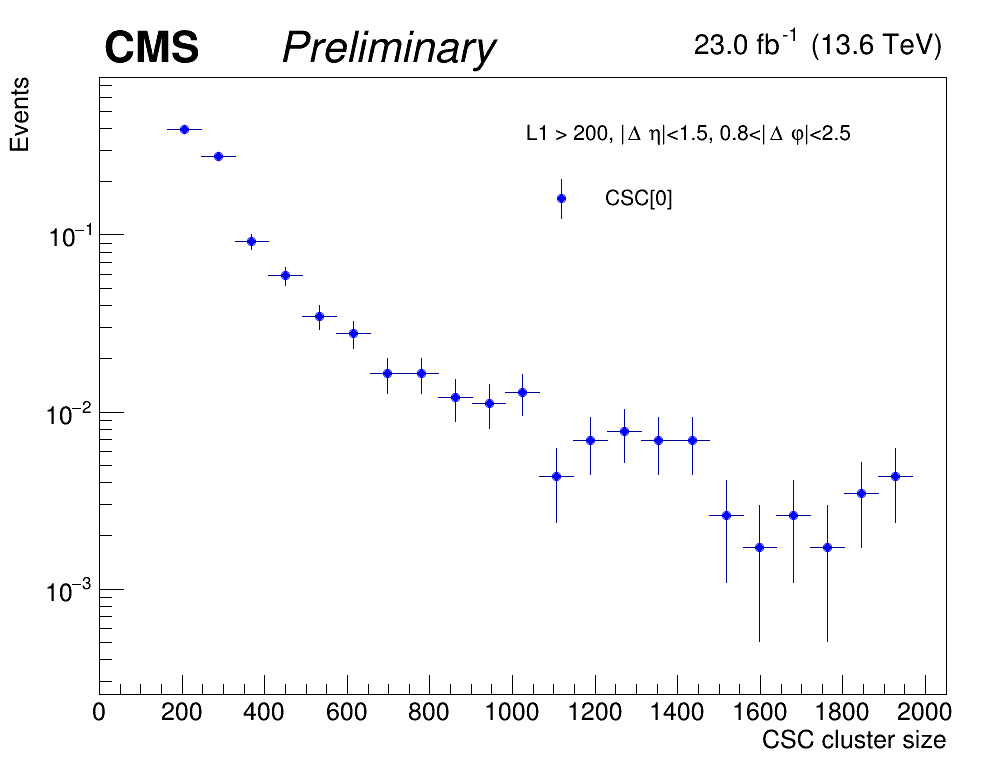

In [79]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.4,0.7,0.37+0.5,0.87)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}
tr_h0 = {}
tr_h1 = {}
can.cd()
scale=False
scale=True

       
for k in ['data']:
        tr_in_1 = tr_in_plateau_1[k]
        tr_in_2 = tr_in_plateau_2[k]
        
        ev_pl_1 = ak.any(tr_in_plateau_1[k],axis=1)
        ev_pl_2 = ak.any(tr_in_plateau_2[k],axis=1)
                
        tmp_size1 = tr_cscClusterSize[k] [ev_pl_1][:,0]
        tmp_size2 = tr_cscClusterSize[k] [ev_pl_2][:,0]
        
        ev_pl_ch = ev_pl_2
        tmp_size_ch = tmp_size2
        X_MIN = x2_min
        
        leg.SetHeader("L1 > 200, |#Delta #eta|<1.5, 0.8<|#Delta #varphi|<2.5")
        lab = "_L1_200_dEta_0_1p5_dphi_0p8_2p5"
        
        print(np.array(tmp_size_ch).shape)
        print(np.array(ev_pl_ch).shape)
        
        tmp_dphi = np.abs( dPhi_csc_csc[k][ev_pl_ch] )
        tmp_deta = np.abs(  dEta_csc_csc[k][ev_pl_ch] )
        tmp_dR = np.abs(  dR_csc_csc[k][ev_pl_ch] )
        tmp_dt = np.abs( dt_csc_csc[k][ev_pl_ch] )
        
        var = cscClusterSize[k][ev_pl_ch][:,0]
        t_var = cscClusterTime[k][ev_pl_ch][:,0]
        tr_t_var = tr_cscClusterTime[k][ev_pl_ch][:,0]
        t_spread_var = cscClusterTimeSpread[k][ev_pl_ch][:,0]
        
        dphi = np.abs(dPhi_csc_csc[k][ev_pl_ch])
        dnn = cscClusterDNN[k][ev_pl_ch][:,0]
        tr_dnn = tr_cscClusterDNN[k][ev_pl_ch][:,0]
        
        cut = (tmp_deta<1.5) & (tmp_dphi<2.5) & (tmp_dphi>0.8) #& (tmp_dR>1.2)
        
        c0 =  (tr_cscClusterSize[k][ev_pl_ch][:,0])
        
        print("Bumps appear depending on dR/dphi cuts!")
        
        bins = [20,50,450]
        #bins = [10,50,1050]
        bins = [25,0,2050]
        #bins = [50,100,200,300,400,800,1000]
        h0[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h0[k].SetLineColor(2)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(2)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        tr_h0[k] = create_TH1D( tr_cscClusterSize[k][ev_pl_ch][cut][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        if scale and tr_h0[k].Integral()>0:tr_h0[k].Scale(1./tr_h0[k].Integral())
            
        tr_h1[k] = create_TH1D( tr_cscClusterSize[k][ev_pl_ch][cut & (c0>200)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        if scale and tr_h1[k].Integral()>0:tr_h1[k].Scale(1./tr_h1[k].Integral())
            
        h1[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (c0>200)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h1[k].SetLineColor(1)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(1)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())

        h2[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (tmp_size_ch>700)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h2[k].SetLineColor(803)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(803)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
        h3[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (tmp_size_ch>1000)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(20)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        h4[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (tmp_size_ch>1500)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h4[k].SetLineColor(8)
        h4[k].SetLineWidth(2)
        h4[k].SetMarkerColor(8)
        h4[k].SetMarkerStyle(20)
        h4[k].SetMarkerSize(1.2)
        if scale and h4[k].Integral()>0:h4[k].Scale(1./h4[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.8)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.00001)
        if 'data' in k:
            #h0[k].Draw('PE same')
            tr_h0[k].SetMarkerStyle(20)
            tr_h0[k].SetMarkerColor(4)
            tr_h0[k].Draw('PE same')
            #tr_h1[k].SetLineColor(2)
            #tr_h1[k].Draw('HISTO same')
            #h1[k].Draw('PE same')
            #h2[k].Draw('PE same')
            #h3[k].Draw('PE same')
            #h4[k].Draw('PE same')
            leg.AddEntry(tr_h0[k],"CSC[0]","PE")
            #leg.AddEntry(h0[k],"CSC[1]","PE")
            #leg.AddEntry(h1[k],"CSC[1] when CSC[0]>200","PE")
            #leg.AddEntry(h2[k],"","PE")
            #leg.AddEntry(h3[k],"","PE")
            #leg.AddEntry(h4[k],"","PE")

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/CSC0_size"+lab+".pdf")
can.Print("plots/V1p19_"+vers+"/CSC0_size"+lab+".png")
#can.Close() 

(3108,)
(9006,)
Bumps appear depending on dR/dphi cuts!


/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` 

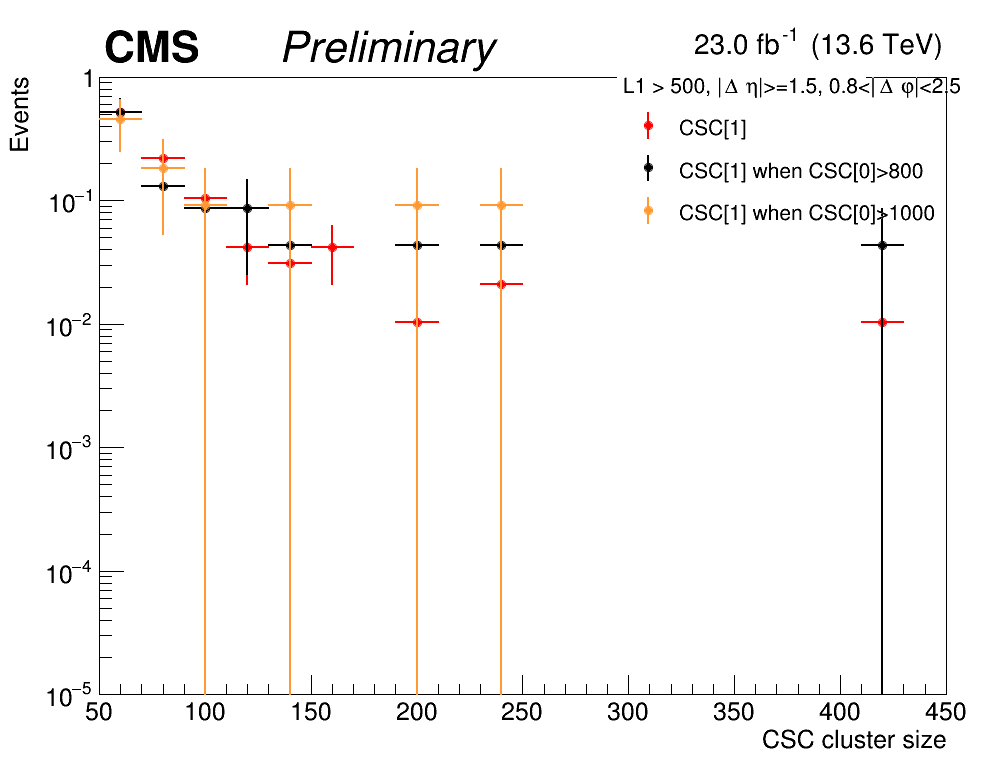

In [83]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.5,0.7,0.37+0.5,0.92)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}
tr_h0 = {}
tr_h1 = {}
can.cd()
scale=False
scale=True

       
for k in ['data']:
        tr_in_1 = tr_in_plateau_1[k]
        tr_in_2 = tr_in_plateau_2[k]
        
        ev_pl_1 = ak.any(tr_in_plateau_1[k],axis=1)
        ev_pl_2 = ak.any(tr_in_plateau_2[k],axis=1)
                
        tmp_size1 = tr_cscClusterSize[k] [ev_pl_1][:,0]
        tmp_size2 = tr_cscClusterSize[k] [ev_pl_2][:,0]
        
        ev_pl_ch = ev_pl_1
        tmp_size_ch = tmp_size1
        X_MIN = x1_min
        
        leg.SetHeader("L1 > 500, |#Delta #eta|>=1.5, 0.8<|#Delta #varphi|<2.5")
        lab = "_L1_500_dEta_1p5_inf_dphi_0p8_2p5"
        
        print(np.array(tmp_size_ch).shape)
        print(np.array(ev_pl_ch).shape)
        
        tmp_dphi = np.abs( dPhi_csc_csc[k][ev_pl_ch] )
        tmp_deta = np.abs(  dEta_csc_csc[k][ev_pl_ch] )
        tmp_dR = np.abs(  dR_csc_csc[k][ev_pl_ch] )
        tmp_dt = np.abs( dt_csc_csc[k][ev_pl_ch] )
        
        var = cscClusterSize[k][ev_pl_ch][:,0]
        t_var = cscClusterTime[k][ev_pl_ch][:,0]
        tr_t_var = tr_cscClusterTime[k][ev_pl_ch][:,0]
        t_spread_var = cscClusterTimeSpread[k][ev_pl_ch][:,0]
        
        dphi = np.abs(dPhi_csc_csc[k][ev_pl_ch])
        dnn = cscClusterDNN[k][ev_pl_ch][:,0]
        tr_dnn = tr_cscClusterDNN[k][ev_pl_ch][:,0]
        
        cut = (tmp_deta>=1.5) & (tmp_dphi<2.5) & (tmp_dphi>0.8) #& (tmp_dR>1.2)
        
        c0 =  (tr_cscClusterSize[k][ev_pl_ch][:,0])
        
        print("Bumps appear depending on dR/dphi cuts!")
        
        bins = [20,50,450]
        #bins = [25,50,1050]
        h0[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h0[k].SetLineColor(2)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(2)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        tr_h0[k] = create_TH1D( tr_cscClusterSize[k][ev_pl_ch][cut][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        if scale and tr_h0[k].Integral()>0:tr_h0[k].Scale(1./tr_h0[k].Integral())
            
        tr_h1[k] = create_TH1D( tr_cscClusterSize[k][ev_pl_ch][cut & (c0>200)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        if scale and tr_h1[k].Integral()>0:tr_h1[k].Scale(1./tr_h1[k].Integral())
            
        h1[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (c0>800)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h1[k].SetLineColor(1)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(1)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())

        h2[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (c0>1000)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h2[k].SetLineColor(801)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(801)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
        h3[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (tmp_size_ch>1000)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(20)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        h4[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (tmp_size_ch>1500)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h4[k].SetLineColor(8)
        h4[k].SetLineWidth(2)
        h4[k].SetMarkerColor(8)
        h4[k].SetMarkerStyle(20)
        h4[k].SetMarkerSize(1.2)
        if scale and h4[k].Integral()>0:h4[k].Scale(1./h4[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.8)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.00001)
        if 'data' in k:
            h0[k].Draw('PE same')
            #tr_h0[k].Draw('HISTO same')
            tr_h1[k].SetLineColor(2)
            #tr_h1[k].Draw('HISTO same')
            h1[k].Draw('PE same')
            h2[k].Draw('PE same')
            #h3[k].Draw('PE same')
            #h4[k].Draw('PE same')
            #leg.AddEntry(tr_h0[k],"CSC[0]","L")
            leg.AddEntry(h0[k],"CSC[1]","PE")
            leg.AddEntry(h1[k],"CSC[1] when CSC[0]>800","PE")
            leg.AddEntry(h2[k],"CSC[1] when CSC[0]>1000","PE")
            #leg.AddEntry(h2[k],"","PE")
            #leg.AddEntry(h3[k],"","PE")
            #leg.AddEntry(h4[k],"","PE")

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/CSC1_size"+lab+".pdf")
can.Print("plots/V1p19_"+vers+"/CSC1_size"+lab+".png")
#can.Close() 

(5898,)
(9006,)
Bumps appear depending on dR/dphi cuts!


/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ROOT.AsCObject(hist), array, weights, return_indices)
/nfs/dust/cms/user/lbenato/anaconda3/envs/mds_regression/lib/python3.7/site-packages/root_numpy/_hist.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` 

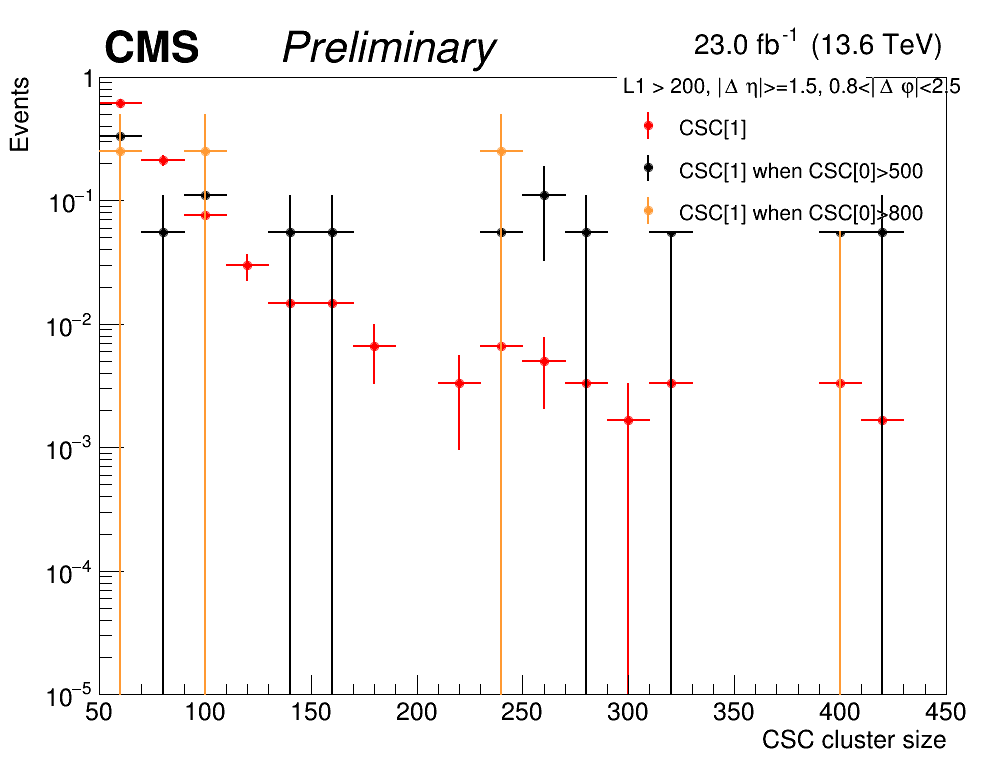

In [84]:
can = rt.TCanvas('c','c', 1000, 800)
leg = rt.TLegend(0.12+0.5,0.7,0.37+0.5,0.92)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
h0 = {}
h1 = {}
h2 = {}
h3 = {}
h4 = {}
tr_h0 = {}
tr_h1 = {}
can.cd()
scale=False
scale=True

       
for k in ['data']:
        tr_in_1 = tr_in_plateau_1[k]
        tr_in_2 = tr_in_plateau_2[k]
        
        ev_pl_1 = ak.any(tr_in_plateau_1[k],axis=1)
        ev_pl_2 = ak.any(tr_in_plateau_2[k],axis=1)
                
        tmp_size1 = tr_cscClusterSize[k] [ev_pl_1][:,0]
        tmp_size2 = tr_cscClusterSize[k] [ev_pl_2][:,0]
        
        ev_pl_ch = ev_pl_2
        tmp_size_ch = tmp_size2
        X_MIN = x2_min
        
        leg.SetHeader("L1 > 200, |#Delta #eta|>=1.5, 0.8<|#Delta #varphi|<2.5")
        lab = "_L1_200_dEta_1p5_inf_dphi_0p8_2p5"
        
        print(np.array(tmp_size_ch).shape)
        print(np.array(ev_pl_ch).shape)
        
        tmp_dphi = np.abs( dPhi_csc_csc[k][ev_pl_ch] )
        tmp_deta = np.abs(  dEta_csc_csc[k][ev_pl_ch] )
        tmp_dR = np.abs(  dR_csc_csc[k][ev_pl_ch] )
        tmp_dt = np.abs( dt_csc_csc[k][ev_pl_ch] )
        
        var = cscClusterSize[k][ev_pl_ch][:,0]
        t_var = cscClusterTime[k][ev_pl_ch][:,0]
        tr_t_var = tr_cscClusterTime[k][ev_pl_ch][:,0]
        t_spread_var = cscClusterTimeSpread[k][ev_pl_ch][:,0]
        
        dphi = np.abs(dPhi_csc_csc[k][ev_pl_ch])
        dnn = cscClusterDNN[k][ev_pl_ch][:,0]
        tr_dnn = tr_cscClusterDNN[k][ev_pl_ch][:,0]
        
        cut = (tmp_deta>=1.5) & (tmp_dphi<2.5) & (tmp_dphi>0.8) #& (tmp_dR>1.2)
        
        c0 =  (tr_cscClusterSize[k][ev_pl_ch][:,0])
        
        print("Bumps appear depending on dR/dphi cuts!")
        
        bins = [20,50,450]
        #bins = [25,50,1050]
        h0[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h0[k].SetLineColor(2)
        h0[k].SetLineWidth(2)
        h0[k].SetMarkerColor(2)
        h0[k].SetMarkerStyle(20)
        h0[k].SetMarkerSize(1.2)
        if scale and h0[k].Integral()>0:h0[k].Scale(1./h0[k].Integral())

        tr_h0[k] = create_TH1D( tr_cscClusterSize[k][ev_pl_ch][cut][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        if scale and tr_h0[k].Integral()>0:tr_h0[k].Scale(1./tr_h0[k].Integral())
            
        tr_h1[k] = create_TH1D( tr_cscClusterSize[k][ev_pl_ch][cut & (c0>200)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        if scale and tr_h1[k].Integral()>0:tr_h1[k].Scale(1./tr_h1[k].Integral())
            
        h1[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (c0>500)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h1[k].SetLineColor(1)
        h1[k].SetLineWidth(2)
        h1[k].SetMarkerColor(1)
        h1[k].SetMarkerStyle(20)
        h1[k].SetMarkerSize(1.2)
        if scale and h1[k].Integral()>0:h1[k].Scale(1./h1[k].Integral())

        h2[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (c0>800)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h2[k].SetLineColor(801)
        h2[k].SetLineWidth(2)
        h2[k].SetMarkerColor(801)
        h2[k].SetMarkerStyle(20)
        h2[k].SetMarkerSize(1.2)
        if scale and h2[k].Integral()>0:h2[k].Scale(1./h2[k].Integral())
        
        h3[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (tmp_size_ch>1000)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h3[k].SetLineColor(4)
        h3[k].SetLineWidth(2)
        h3[k].SetMarkerColor(4)
        h3[k].SetMarkerStyle(20)
        h3[k].SetMarkerSize(1.2)
        if scale and h3[k].Integral()>0:h3[k].Scale(1./h3[k].Integral())
            
        h4[k] = create_TH1D( cscClusterSize[k][ev_pl_ch][cut & (tmp_size_ch>1500)][:,0],title="",axis_title = ['CSC cluster size','Events'], binning=bins)
        h4[k].SetLineColor(8)
        h4[k].SetLineWidth(2)
        h4[k].SetMarkerColor(8)
        h4[k].SetMarkerStyle(20)
        h4[k].SetMarkerSize(1.2)
        if scale and h4[k].Integral()>0:h4[k].Scale(1./h4[k].Integral())
            
        if not scale:
            h0[k].SetMinimum(0.8)
            h0[k].SetMaximum(1.e5)
        else:
            h0[k].SetMaximum(1)
            h0[k].SetMinimum(0.00001)
        if 'data' in k:
            h0[k].Draw('PE same')
            #tr_h0[k].Draw('HISTO same')
            tr_h1[k].SetLineColor(2)
            #tr_h1[k].Draw('HISTO same')
            h1[k].Draw('PE same')
            h2[k].Draw('PE same')
            #h3[k].Draw('PE same')
            #h4[k].Draw('PE same')
            #leg.AddEntry(tr_h0[k],"CSC[0]","L")
            leg.AddEntry(h0[k],"CSC[1]","PE")
            leg.AddEntry(h1[k],"CSC[1] when CSC[0]>500","PE")
            leg.AddEntry(h2[k],"CSC[1] when CSC[0]>800","PE")
            #leg.AddEntry(h2[k],"","PE")
            #leg.AddEntry(h3[k],"","PE")
            #leg.AddEntry(h4[k],"","PE")

leg.Draw()
can.SetRightMargin(0.05)
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.96,top_marg_lumi=0.965)
can.SetLogy()
can.Draw()
can.Print("plots/V1p19_"+vers+"/CSC1_size"+lab+".pdf")
can.Print("plots/V1p19_"+vers+"/CSC1_size"+lab+".png")
#can.Close() 

In [81]:
x_cut_scan_list = np.linspace(1.5,3.1,8+1)
x_cut_scan_list = [300,400,500,600,700,800,900,1000,1200]

N_CUT = 240

time_cut_string = "IT"
plot_string_plus = ""#plot_string+"_"+time_cut_string+"_dR"+str( dr_min_list[0] ).replace(".","p")
leghead = ""#"|#Delta#eta|<1.9, "+time_cut_string+", #DeltaR>"+str(dr_min_list[0])+","

#one per min dphi cut
bkg_rate = {}
#bkg_unc = {}
observation = {}
signal_rate = {}

normalization = 1
normalization = pedro_factor
print(normalization)

for x_cut_scan in x_cut_scan_list:
    signal_rate[x_cut_scan] = {}

print(' \t x\t B\t C\t D\t A\t A pred\t\t zval\t perc')
if category==1:
    #Signal
    #Data
    for k in ['data','signal']:

        
        tr_in_1 = tr_in_plateau_1[k]
        tr_in_2 = tr_in_plateau_2[k]
        
        ev_pl_1 = ak.any(tr_in_plateau_1[k],axis=1)
        ev_pl_2 = ak.any(tr_in_plateau_2[k],axis=1)

                
        tmp_size1 = tr_cscClusterSize[k] [ev_pl_1][:,0]
        tmp_size2 = tr_cscClusterSize[k] [ev_pl_2][:,0]
        
        ev_pl_ch = ev_pl_2
        tmp_size_ch = tmp_size2
        X_MIN = x2_min
        
        tmp_dphi = np.abs( dPhi_csc_csc[k][ev_pl_ch] )
        tmp_deta = np.abs(  dEta_csc_csc[k][ev_pl_ch] )
        tmp_dR = np.abs(  dR_csc_csc[k][ev_pl_ch] )
        tmp_dt = np.abs( dt_csc_csc[k][ev_pl_ch] )

        
        var = cscClusterSize[k][ev_pl_ch][:,0]
        t_var = cscClusterTime[k][ev_pl_ch][:,0]
        tr_t_var = tr_cscClusterTime[k][ev_pl_ch][:,0]
        t_spread_var = cscClusterTimeSpread[k][ev_pl_ch][:,0]
        
        dphi = np.abs(dPhi_csc_csc[k][ev_pl_ch])
        dnn = cscClusterDNN[k][ev_pl_ch][:,0]
        tr_dnn = tr_cscClusterDNN[k][ev_pl_ch][:,0]
        
        #tmp_cut = (np.abs(tmp_deta)<1.9) & (np.abs(t_var)<15) & (np.abs(t_spread_var)<20) & (np.abs(tr_t_var)<15) & (dnn>0.3) & (tr_dnn>0.3)       
        #cut_tr_small = ( (tmp_size2 > x2_min) & (tmp_size2 < x2_cut) )#(tmp_dphi>=PHI_MIN) & (tmp_dphi<PHI_CUT)
        #cut_tr_large = ( (tmp_size2 >= x2_cut) & (tmp_size2 < x2_max) )

        tmp_cut = (tmp_deta>1.9) & (tmp_dphi>1.2) & (tmp_dphi<2.8)# & (np.abs(t_spread_var)<20) & (np.abs(t_var)<15) & (np.abs(tr_t_var)<15)
        tmp_cut = (tmp_deta<1.9) & (tmp_dphi>0.8) & (tmp_dphi<2.8) & (dnn>0.3) & (tr_dnn>0.3)                        

        #print(ak.num(tmp_deta,axis=0))
        #print(ak.num(tmp_cut,axis=0))

        #print("xxx")
        
        #print(ak.num(var,axis=0))
        #print(ak.num(tmp_size2,axis=0))
        
        #print(tmp_cut)
        #print(tmp_dphi)
        #print(var)
        #print(tmp_size2)
        #continue
        
        tmp_cut = (np.abs(tmp_deta)>=1.5)# & ev_pl_2
        #tmp_cut = (np.abs(tmp_deta)<1.5) #& ev_pl_2
        #tmp_cut = (np.abs(tmp_deta)<1.5) & (dnn>0.3) & (tr_dnn>0.3)
        
        PHI_MIN = 0.8
        PHI_MAX = 2.5
                
        for x_cut_scan in x_cut_scan_list:
            if x_cut_scan<=X_MIN: continue
            if 'data' in k:
                a[k],b[k],c[k],d[k],pred,unc_pred, p_value, z_value = run_abcd(
                    var,tmp_size_ch,
                    N_MIN,N_CUT,N_MAX,
                    X_MIN,x_cut_scan,X_MAX,
                    tmp_cut
                    )
                print("%s\t %i\t %i\t %i\t %i\t %i\t %.2f +- %.2f\t %.2f\t %.2f" % (k,x_cut_scan,b[k],c[k],d[k],a[k],pred,unc_pred,z_value, 100*(pred-a[k])/a[k]))
                observation[x_cut_scan] = [ pred,b[k],c[k],d[k] ]
                bkg_rate[x_cut_scan] = [ pred,b[k],c[k],d[k] ]
                #bkg_unc[x_min_scan] = [ unc_pred,np.sqrt(b[k]),np.sqrt(c[k]),np.sqrt(d[k]) ]
            else:
                ma,mb,mc,md = return_abcd_masks(
                    var,tmp_size_ch,
                    N_MIN,N_CUT,N_MAX,
                    X_MIN,x_cut_scan,X_MAX,
                    tmp_cut
                    )
                a[k] = (np.sum(weight[k][ ma ]))#*lumi
                b[k] = (np.sum(weight[k][ mb ]))#*lumi
                c[k] = (np.sum(weight[k][ mc ]))#*lumi
                d[k] = (np.sum(weight[k][ md ]))#*lumi
                print(k,x_cut_scan,a[k],b[k],c[k],d[k], a[k]+b[k]+c[k]+d[k])
                signal_rate[x_cut_scan]['ggH'] = [ a[k]*normalization,b[k]*normalization,c[k]*normalization,d[k]*normalization ]



0.02607826429649114
 	 x	 B	 C	 D	 A	 A pred		 zval	 perc
data	 300	 183	 935	 8	 21	 1.57 +- 0.12	 -inf	 -92.54
data	 400	 55	 1063	 13	 16	 0.67 +- 0.09	 -inf	 -95.80
data	 500	 18	 1100	 19	 10	 0.31 +- 0.07	 -inf	 -96.89
data	 600	 10	 1108	 22	 7	 0.20 +- 0.06	 -inf	 -97.16
data	 700	 5	 1113	 25	 4	 0.11 +- 0.05	 -4.19	 -97.19
data	 800	 3	 1115	 26	 3	 0.07 +- 0.04	 -3.70	 -97.67
data	 900	 2	 1116	 27	 2	 0.05 +- 0.03	 -2.95	 -97.58
data	 1000	 2	 1116	 28	 1	 0.05 +- 0.04	 -1.65	 -94.98
data	 1200	 1	 1117	 28	 1	 0.03 +- 0.03	 -1.93	 -97.49
signal 300 208.4805 718.0994 532.78345 115.822495 1575.1859
signal 400 138.987 416.96097 833.92194 185.316 1575.1859
signal 500 92.658 115.822495 1135.0605 231.645 1575.186
signal 600 23.1645 46.329 1204.5542 301.1385 1575.1863
signal 700 0.0 0.0 1250.8833 324.30298 1575.1863
signal 800 0.0 0.0 1250.8833 324.30298 1575.1863
signal 900 0.0 0.0 1250.8833 324.30298 1575.1863
signal 1000 0.0 0.0 1250.8833 324.30298 1575.1863
signal 1200 0.0 0.

In [41]:
outDataCardsDir="/afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/MDS_run3/datacards/V1p19/v6/"
modelName="ggH_HToSSTobbbb_MH-125_MS-15_CTau1000"
m=15
ct=1000
bkg_unc = [1.]
bkg_unc_name = ["syst"]
sig_unc = {}
sig_unc_name = []
signal_region = 'a'
prefix = 'csccsc_'

for phi_cut_scan in phi_cut_scan_list:
    outdir = outDataCardsDir+'phi_cut_scan/'
    if phi_cut_scan<=PHI_MIN:
        continue
    if not os.path.isdir(outdir): os.mkdir(outdir)
    make_datacard_2tag(
        outdir,
        modelName+"_"+str(phi_cut_scan).replace(".","p"),  
        signal_rate[phi_cut_scan], 
        normalization, 
        bkg_rate[phi_cut_scan], 
        observation[phi_cut_scan], 
        bkg_unc, 
        bkg_unc_name, 
        sig_unc, 
        sig_unc_name,
        signal_region, 
        prefix
    )

NameError: name 'phi_cut_scan_list' is not defined

In [ ]:
for phi_cut_scan in phi_cut_scan_list:
    if phi_cut_scan<=PHI_MIN:continue
    print("\n")
    print("+++  ")
    print("+++  ", phi_cut_scan )
    print("+++  ")
    outdir = outDataCardsDir+'/phi_cut_scan/'
    text_file = open(outdir+modelName+"_"+str(phi_cut_scan).replace(".","p")+".txt", "r")
    for line in text_file:
        print(line.strip())
    text_file.close()
    print("\n")

## Submit combine with condor

In [124]:
combine_dir = "/afs/desy.de/user/l/lbenato/cms-lpc-llp_combine/CMSSW_11_3_4/src/HiggsAnalysis/CombinedLimit/"
condor_dir = combine_dir + "condor_V1p19_v6/"
TOYS=False
blind = True
NCPUS   = 1
MEMORY  = 512
RUNTIME = 3600

if not os.path.isdir(condor_dir): os.mkdir(condor_dir)
else:
    print("Warning, directory exists, deleting old condor outputs ... ")
    os.system("ls " + condor_dir)
    os.system("rm " + condor_dir + "/*sh")
    os.system("rm " + condor_dir + "/*submit")
    os.system("rm " + condor_dir + "/*txt")

print("\n")
print("Condor stuff being stored in ", condor_dir)
print("\n")
original_location = os.popen("pwd").read()    

for phi_cut_scan in phi_cut_scan_list:
    if phi_cut_scan<=PHI_MIN:continue
    outdir = outDataCardsDir+'/phi_cut_scan/'
    results = outDataCardsDir+'/phi_cut_scan/'+'combine_results/'
    if not os.path.isdir(results): os.mkdir(results)
    card_name = modelName+"_"+str(phi_cut_scan).replace(".","p")#+".txt"
    #print(card_name)
    #os.system('cat '+card_name)
    #print("\n")
    
    if TOYS:
        print("Toys - to be implemented")
    else:
        os.chdir(condor_dir)
        os.system("pwd")
        print("----->")
        print("Doing Asymptotic!!!!!!!!!")
        with open('job_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.sh', 'w') as fout:
            fout.write("#!/bin/sh\n")
            fout.write("source /etc/profile.d/modules.sh\n")
            fout.write("module use -a /afs/desy.de/group/cms/modulefiles/\n")
            fout.write("module load cmssw\n")
            fout.write('cd '+combine_dir+' \n')
            fout.write("cmsenv\n")
            fout.write("echo Running on: " + outdir+card_name+".txt from directory: \n")
            fout.write("pwd \n")
            if blind:
                fout.write("combine -M AsymptoticLimits --datacard " + outdir+card_name+".txt " + "  --run blind -m " + str(m) + " -n "+str(phi_cut_scan).replace(".","p")+" \n")
                #--SetParameters norm=1 --freezeParameters norm
            else:
                fout.write("combine -M AsymptoticLimits --datacard " + outdir+card_name+".txt " + " -m " + str(m) + " -n " +str(phi_cut_scan).replace(".","p")+ " \n")
        os.system('chmod 755 job_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.sh')

        with open('submit_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.submit', 'w') as fout:
            fout.write('executable   = ' + condor_dir + '/job_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.sh \n')
            fout.write('output       = ' + condor_dir + '/out_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.txt \n')
            fout.write('error        = ' + condor_dir + '/error_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.txt \n')
            fout.write('log          = ' + condor_dir + '/log_m'+ str(m) +'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+ '.txt \n')
            fout.write(' \n')
            fout.write('Requirements = OpSysAndVer == "CentOS7" \n')
            fout.write(' \n')
            fout.write('Request_Cpus = ' + str(NCPUS) + ' \n')
            fout.write('Request_Memory = ' + str(MEMORY) + ' \n')
            #fout.write('+RequestRuntime = ' + str(RUNTIME) + ' \n')                                                                                        
            fout.write('batch_name = m'+str(m)+'ct'+str(ct)+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'\n')
            fout.write('queue 1 \n')

        #submit condor                                                                                                                                      
        #os.system('condor_submit ' + 'submit_m'+str(m)+'_ctau'+str(ct)+'_phi'+str(phi_cut_scan).replace(".","p")+'.submit' + ' \n')
        os.system("sh job_m"+str(m)+"_ctau"+str(ct)+"_phi"+str(phi_cut_scan).replace(".","p")+".sh > "+condor_dir + "/log_m"+ str(m) +"_ctau"+str(ct)+"_phi"+str(phi_cut_scan).replace(".","p")+".txt ")
        os.system("cat "+ condor_dir + "/log_m"+ str(m) +"_ctau"+str(ct)+"_phi"+str(phi_cut_scan).replace(".","p")+".txt | grep -e Observed -e Expected | awk '{print $NF}' > " + results + "/" + card_name +".txt \n")
        print("Results saved in "+results + card_name +".txt")
        os.chdir(original_location[:-1])
                
#os.system("eval `scramv1 runtime -sh`")

Warning, directory exists, deleting old condor outputs ... 


Condor stuff being stored in  /afs/desy.de/user/l/lbenato/cms-lpc-llp_combine/CMSSW_11_3_4/src/HiggsAnalysis/CombinedLimit/condor_V1p19_v6/


----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/MDS_run3/datacards/V1p19/v6//phi_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_1p5.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/MDS_run3/datacards/V1p19/v6//phi_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_1p7.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/MDS_run3/datacards/V1p19/v6//phi_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_1p9.txt
----->
Doing Asymptotic!!!!!!!!!
Results saved in /afs/desy.de/user/l/lbenato/cms-lpc-llp_repo/MDS_run3/datacards/V1p19/v6//phi_cut_scan/combine_results/ggH_HToSSTobbbb_MH-125_MS-15_CTau1000_2p1.txt


### Read and plot the limits

['0.0158', '0.0199', '0.0259', '0.0345', '0.0459']
['0.0140', '0.0176', '0.0229', '0.0314', '0.0419']
['0.0134', '0.0166', '0.0220', '0.0300', '0.0407']
['0.0110', '0.0143', '0.0190', '0.0272', '0.0373']
['0.0099', '0.0132', '0.0181', '0.0253', '0.0359']
['0.0091', '0.0118', '0.0171', '0.0244', '0.0352']
['0.0088', '0.0122', '0.0171', '0.0255', '0.0367']
['0.0113', '0.0153', '0.0220', '0.0335', '0.0473']
['0.0263', '0.0349', '0.0503', '0.0699', '0.0845']
[1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9000000000000004, 3.1]
[0.0259, 0.0229, 0.022, 0.019, 0.0181, 0.0171, 0.0171, 0.022, 0.0503, 0.0259, 0.0229, 0.022, 0.019, 0.0181, 0.0171, 0.0171, 0.022, 0.0503]
Info: written plots/V1p19_v6_Pedro_newDNN_skim/ABCD_limits_scan_dphi_cut_IT_dR0p5.root


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file plots/V1p19_v6_Pedro_newDNN_skim/ABCD_limits_scan_dphi_cut_IT_dR0p5.pdf has been created
Info in <TCanvas::Print>: png file plots/V1p19_v6_Pedro_newDNN_skim/ABCD_limits_scan_dphi_cut_IT_dR0p5.png has been created


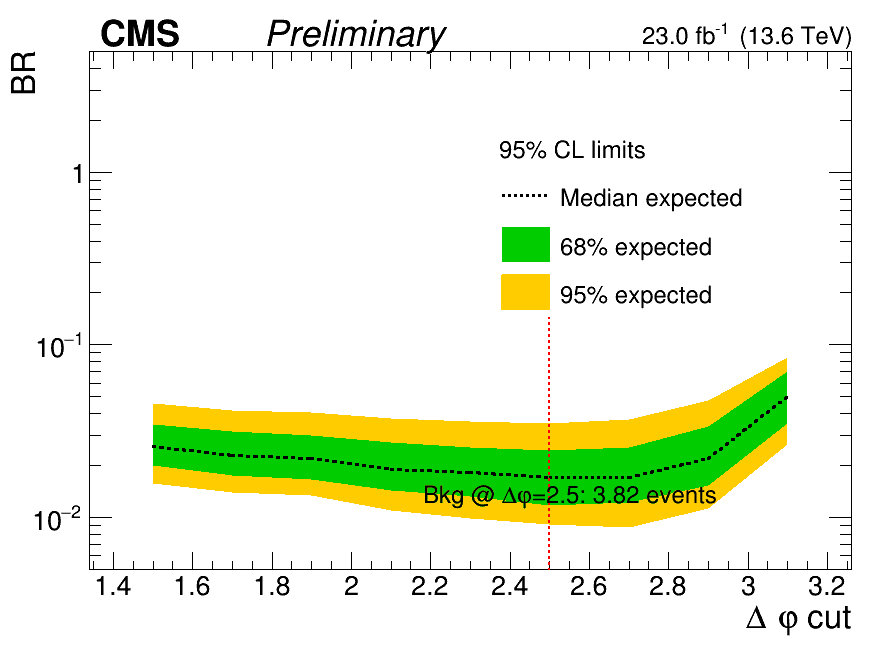

In [125]:
results = outDataCardsDir+'/phi_cut_scan/'+'combine_results/'
exp = []
xval = []
obs = {}
mean_val = {}
sigma_2_up = {}
sigma_1_up = {}
sigma_1_down = {}
sigma_2_down = {}
for phi_cut_scan in phi_cut_scan_list:
    if phi_cut_scan<=PHI_MIN:continue
    card_name = modelName+"_"+str(phi_cut_scan).replace(".","p")
    
    if not os.path.isfile(results+card_name+".txt"):
        continue
    card = open( results+card_name+".txt", 'r')
    val = card.read().splitlines()
    if len(val) == 0:
        continue
    if len(val) != 6 and not blind:
        continue
    print(val)
    
    if blind:
        sigma_2_down[phi_cut_scan] = float(val[0])
        sigma_1_down[phi_cut_scan] = float(val[1])
        mean_val[phi_cut_scan]     = float(val[2])
        exp.append(float(val[2]))
        sigma_1_up[phi_cut_scan]   = float(val[3])
        sigma_2_up[phi_cut_scan]   = float(val[4])
    else:
        obs[phi_cut_scan]          = float(val[0])
        sigma_2_down[phi_cut_scan] = float(val[1])
        sigma_1_down[phi_cut_scan] = float(val[2])
        mean_val[phi_cut_scan]     = float(val[3])
        exp.append(float(val[3]))
        sigma_1_up[phi_cut_scan]   = float(val[4])
        sigma_2_up[phi_cut_scan]   = float(val[5])
        
Obs0s = rt.TGraph()
Exp0s = rt.TGraph()
Exp1s = rt.TGraphAsymmErrors()
Exp2s = rt.TGraphAsymmErrors()

n=0
for phi_cut_scan in phi_cut_scan_list:                                                                                                    
    if phi_cut_scan not in mean_val.keys():
        continue
    if not blind:
        Obs0s.SetPoint(n, phi_cut_scan, obs[phi_cut_scan])
    #if phi_cut_scan==2. or phi_cut_scan==2.1:
    #    continue
    Exp0s.SetPoint(n, phi_cut_scan, mean_val[phi_cut_scan])
    Exp1s.SetPoint(n, phi_cut_scan, mean_val[phi_cut_scan])
    Exp1s.SetPointError(n, 0., 0., mean_val[phi_cut_scan]-sigma_1_down[phi_cut_scan], sigma_1_up[phi_cut_scan]-mean_val[phi_cut_scan])
    Exp2s.SetPoint(n, phi_cut_scan, mean_val[phi_cut_scan])
    Exp2s.SetPointError(n, 0., 0., mean_val[phi_cut_scan]-sigma_2_down[phi_cut_scan], sigma_2_up[phi_cut_scan]-mean_val[phi_cut_scan])
    n+=1
    
Exp2s.SetLineWidth(2)
Exp2s.SetLineStyle(1)
Exp0s.SetLineStyle(2)
Exp0s.SetLineWidth(3)                                                                                                                            
Obs0s.SetLineStyle(1)
Obs0s.SetLineWidth(3)                                                                                                                          
Exp1s.SetFillColor(417)
Exp1s.SetLineColor(417)
Exp2s.SetFillColor(800)
Exp2s.SetLineColor(800)
Exp2s.GetXaxis().SetTitle("#Delta #varphi cut")
Exp2s.GetYaxis().SetTitle("BR")
Exp2s.GetXaxis().SetNoExponent(True)
Exp2s.GetXaxis().SetMoreLogLabels(True)
Exp2s.GetXaxis().SetTitleSize(0.048)
Exp2s.GetYaxis().SetTitleSize(0.048)                                                                                                                                           
Exp2s.GetXaxis().SetTitleOffset(0.9)
Exp2s.GetYaxis().SetTitleOffset(0.85)

leg = rt.TLegend(0.55, 0.525-0.015, 0.9-0.05, 0.825-0.015)
leg.SetBorderSize(0)
leg.SetHeader("95% CL limits")
leg.SetTextSize(0.04)
c1 = rt.TCanvas("c1", "Exclusion Limits", 900, 675)
c1.cd()
c1.GetPad(0).SetBottomMargin(0.12)
c1.GetPad(0).SetTopMargin(0.08)
c1.GetPad(0).SetRightMargin(0.05)
c1.GetPad(0).SetTicks(1, 1)
c1.GetPad(0).SetLogy()

leg.AddEntry(Exp0s,  "Median expected", "l")
leg.AddEntry(Exp1s, "68% expected", "f")
leg.AddEntry(Exp2s, "95% expected", "f")
if not blind:
    leg.AddEntry(Obs0s, "Observed", "l")
Exp2s.GetXaxis().SetTitleSize(0.055)
Exp2s.GetYaxis().SetTitleSize(0.055)
Exp2s.GetXaxis().SetLabelSize(0.045)                                                                                 
Exp2s.GetYaxis().SetLabelSize(0.045)

for mv in mean_val.keys():
    xval.append(mv)
    exp.append(mean_val[mv])

print(xval)
print(exp)
best_phi = rt.TLine(xval[ np.argmin(exp) ],0.005,xval[ np.argmin(exp) ],1)
best_phi.SetLineColor(2)
best_phi.SetLineStyle(2)
best_phi.SetLineWidth(2)


Exp2s.SetMinimum(0.005)
Exp2s.SetMaximum(5)
Exp2s.Draw("A3")
Exp1s.Draw("SAME, 3")
Exp0s.Draw("SAME, L")
if not blind:
    Obs0s.Draw("SAME, L")
best_phi.Draw("SAME, L")
leg.Draw()

latex = rt.TLatex()
latex.SetNDC()
latex.SetTextAlign(33)
latex.SetTextSize(0.04)
latex.SetTextFont(42)
latex.DrawLatex(0.8,0.25, ("Bkg @ #Delta#varphi=%s: %.2f events" % ( str(xval[ np.argmin(exp) ]),bkg_rate[ xval[ np.argmin(exp) ] ] [0])))

c1.Draw()
drawCMS(lumi, "Preliminary", ERA="", onTop=True,left_marg_CMS=0.2,top_marg_cms=0.97,top_marg_lumi=0.965)

c1.Print("plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".pdf")
c1.Print("plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".png")
#Store graphs for future comparisons
newFile = rt.TFile("plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".root", "RECREATE")
newFile.cd()
Exp0s.Write("exp")
Exp1s.Write("1sigma")
Exp2s.Write("2sigma")
c1.Write()
newFile.Close()
print("Info: written "+"plots/V1p19_"+vers+"/ABCD_limits_scan_dphi_cut"+plot_string_plus+".root")

## ABCD with cluster sizes